# BT5 – Whisper binned transcripts (10/20/30s) Bloom analysis

This notebook scans each participant folder for:

- `whisper_large_results/*.csv` files produced by Whisper binning (**10s / 20s / 30s**)

It then applies the **same Bloom verb preprocessing** used in the BT notebooks (spaCy lemmatization + WordNet verb verification + stopword/aux filtering) and scores verbs using your **BT4 artefacts**:

- `model.pkl`
- `calibration_cdfs.json`
- `thresholds.json`
- `metadata.json`
- (optional) `bt4_scorer.py`

Outputs are saved to `results/` and each binning is analyzed **in separate cells** for easy comparison.


In [1]:
# ===== 0) Paths (run first) =====
from pathlib import Path

BASE_DIR = Path.cwd()  # run this notebook from the root "Participants Data" folder if possible
RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

# Participants directory: contains one folder per participant
PARTICIPANTS_DIR = BASE_DIR

# If you run notebook from elsewhere, uncomment and set manually:
# PARTICIPANTS_DIR = Path("/home/talha4/Downloads/Participants Data")

print("BASE_DIR:", BASE_DIR)
print("PARTICIPANTS_DIR:", PARTICIPANTS_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


BASE_DIR: d:\Thesis\Papers\Bloom's Taxonomy\Blooms-Taxonomy-Verbs-classification-on-Think-aloud-Protocol-s-Transcripts
PARTICIPANTS_DIR: d:\Thesis\Papers\Bloom's Taxonomy\Blooms-Taxonomy-Verbs-classification-on-Think-aloud-Protocol-s-Transcripts
RESULTS_DIR: d:\Thesis\Papers\Bloom's Taxonomy\Blooms-Taxonomy-Verbs-classification-on-Think-aloud-Protocol-s-Transcripts\results


In [2]:
# ===== 1) Dependencies + NLTK resources (run once per environment) =====
# If you get import errors for spacy/nltk/sentence-transformers, install them in your active env:
#   pip install -U spacy nltk sentence-transformers scikit-learn pandas numpy matplotlib
#   python -m spacy download en_core_web_sm

import nltk

# Download required resources if missing
for pkg in ["wordnet", "omw-1.4", "stopwords"]:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg)

print("NLTK resources OK.")


NLTK resources OK.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\talha4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\talha4\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# ===== 2) Load BT4 artefacts (model + calibration + thresholds) =====
import json, pickle
import numpy as np
import joblib
from pathlib import Path
import sklearn, sys

print("Python:", sys.version.split()[0])
print("sklearn:", sklearn.__version__)

DEFAULT_LABELS = ["Kn","Cm","Ap","An","Sn","Ev"]

# ---- Paths ----
BASE_DIR  = BASE_DIR
MODEL_DIR = BASE_DIR / "Model"   # confirmed folder name

MODEL_PKL = MODEL_DIR / "model.pkl"
CDF_JSON  = MODEL_DIR / "calibration_cdfs.json"
THR_JSON  = MODEL_DIR / "thresholds.json"
META_JSON = MODEL_DIR / "metadata.json"

for f in [MODEL_PKL, CDF_JSON, THR_JSON, META_JSON]:
    if not f.exists():
        raise FileNotFoundError(f"Missing required artefact: {f}")

# ---- Load model.pkl robustly (joblib first, then pickle) ----
def load_model(path: Path):
    head = path.read_bytes()[:8]
    print("model.pkl header bytes:", head)

    try:
        m = joblib.load(path)
        print("Loaded model with joblib:", type(m))
        return m
    except Exception as e_joblib:
        print("joblib.load failed:", repr(e_joblib))

    try:
        with open(path, "rb") as f:
            m = pickle.load(f)
        print("Loaded model with pickle:", type(m))
        return m
    except Exception as e_pickle:
        print("pickle.load failed:", repr(e_pickle))

    raise RuntimeError("Could not load model.pkl with joblib or pickle.")

clf = load_model(MODEL_PKL)

# ---- Load JSON artefacts ----
cdf_data_raw   = json.loads(CDF_JSON.read_text())
thresholds_raw = json.loads(THR_JSON.read_text())
metadata       = json.loads(META_JSON.read_text())

# ---- Prefer labels from metadata if present ----
LABELS = None
for k in ["labels", "class_labels", "level_labels", "LABELS", "classes"]:
    if k in metadata and isinstance(metadata[k], list) and metadata[k]:
        LABELS = metadata[k]
        break
LABELS = LABELS or DEFAULT_LABELS
print("LABELS:", LABELS)

# ---- Best-effort embedder name from metadata ----
def _get_embedder_name(meta: dict) -> str:
    keys = ["embedding_model","embedding_model_name","sentence_transformer","st_model",
            "embedder","embed_model","model_name","encoder"]
    for k in keys:
        if k in meta and isinstance(meta[k], str) and meta[k].strip():
            return meta[k].strip()
    for v in meta.values():
        if isinstance(v, dict):
            for k in keys:
                if k in v and isinstance(v[k], str) and v[k].strip():
                    return v[k].strip()
    return "all-mpnet-base-v2"

EMBEDDER_NAME = _get_embedder_name(metadata)
print("Embedding model:", EMBEDDER_NAME)

# ---- Normalize calibration_cdfs.json into dict {label: spec} ----
def normalize_cdf_json(cdf_json, labels):
    if isinstance(cdf_json, dict):
        return cdf_json
    if isinstance(cdf_json, list):
        # list aligned with LABELS order
        if len(cdf_json) == len(labels):
            return {labels[i]: cdf_json[i] for i in range(len(labels))}
        # list of dicts with embedded label
        if all(isinstance(it, dict) for it in cdf_json):
            label_keys = ["label", "level", "name", "class", "key"]
            out = {}
            for it in cdf_json:
                lab = None
                for lk in label_keys:
                    if lk in it and isinstance(it[lk], str):
                        lab = it[lk].strip()
                        break
                if lab is not None:
                    out[lab] = it
            if out:
                return out
    raise ValueError(f"Unsupported calibration_cdfs.json format: type={type(cdf_json)}")

cdf_data = normalize_cdf_json(cdf_data_raw, LABELS)
print("CDF keys (sample):", list(cdf_data.keys())[:10])

# ---- Thresholds: file is nested under levels + thresholds_oof_aligned/thresholds_tuning ----
print("thresholds_raw type:", type(thresholds_raw))
if isinstance(thresholds_raw, dict):
    print("thresholds_raw keys:", list(thresholds_raw.keys()))
else:
    print("thresholds_raw len:", len(thresholds_raw))

THRESHOLD_SOURCE = "thresholds_oof_aligned"  # change to "thresholds_tuning" if you want

def normalize_thresholds(thr_json, labels, source=THRESHOLD_SOURCE):
    """
    Returns dict {label: float}.

    Handles your observed structure:
      {"levels":[...], "thresholds_tuning":..., "thresholds_oof_aligned":...}

    Also handles:
      - dict keyed by labels
      - list aligned with labels
      - numeric-index dict {"0":..., "1":...}
      - list of dicts with label+value
    """
    # --- Helper: map (levels, values) -> dict ---
    def map_levels(levels_list, vals):
        # vals can be list of floats, or dict keyed by label, or list of dicts
        if isinstance(vals, dict):
            # if keyed by label already
            return {str(k): float(v) for k, v in vals.items()}
        if isinstance(vals, list):
            # list of floats aligned to levels
            if len(vals) == len(levels_list) and all(isinstance(x, (int, float)) for x in vals):
                return {str(levels_list[i]): float(vals[i]) for i in range(len(levels_list))}
            # list of dicts with label+value
            if all(isinstance(it, dict) for it in vals):
                out = {}
                for it in vals:
                    lab = it.get("label") or it.get("level") or it.get("name") or it.get("class")
                    val = it.get("threshold") or it.get("tau") or it.get("value") or it.get("thr")
                    if isinstance(lab, str) and val is not None:
                        out[lab.strip()] = float(val)
                if out:
                    return out
        raise ValueError("Cannot map thresholds from provided levels/vals structure.")

    # --- Case 1: dict keyed by labels directly ---
    if isinstance(thr_json, dict):
        # direct label keys?
        if any(isinstance(k, str) and k.lower() == labels[0].lower() for k in thr_json.keys()):
            return {k: float(v) for k, v in thr_json.items()}

        # your known nested format
        if "levels" in thr_json and isinstance(thr_json["levels"], list):
            levels_list = thr_json["levels"]

            # try selected source first
            if source in thr_json:
                return map_levels(levels_list, thr_json[source])

            # fallback order
            for k in ["thresholds_oof_aligned", "thresholds_tuning", "thresholds", "tau", "taus", "values"]:
                if k in thr_json:
                    return map_levels(levels_list, thr_json[k])

        # numeric-index dict
        keys = set(str(k) for k in thr_json.keys())
        if all(str(i) in keys for i in range(len(labels))):
            return {labels[i]: float(thr_json[str(i)]) for i in range(len(labels))}

        # unwrap common single nesting
        for k in ["thresholds", "tau", "taus", "per_level", "per_label", "values", "thr"]:
            if k in thr_json:
                return normalize_thresholds(thr_json[k], labels, source=source)

    # --- Case 2: list aligned with labels ---
    if isinstance(thr_json, list):
        if len(thr_json) == len(labels) and all(isinstance(x, (int, float)) for x in thr_json):
            return {labels[i]: float(thr_json[i]) for i in range(len(labels))}
        if all(isinstance(it, dict) for it in thr_json):
            out = {}
            for it in thr_json:
                lab = it.get("label") or it.get("level") or it.get("name") or it.get("class")
                val = it.get("threshold") or it.get("tau") or it.get("value") or it.get("thr")
                if isinstance(lab, str) and val is not None:
                    out[lab.strip()] = float(val)
            if out:
                return out

    raise ValueError(f"Unsupported thresholds.json format: type={type(thr_json)}")

thresholds = normalize_thresholds(thresholds_raw, LABELS, source=THRESHOLD_SOURCE)
print("Normalized thresholds keys:", list(thresholds.keys()))
print("Normalized thresholds:", thresholds)

# ---- Case-insensitive key helper ----
def _key_ci(d, key):
    if key in d:
        return key
    for k in d.keys():
        if isinstance(k, str) and k.lower() == key.lower():
            return k
    return None

# ---- Robust CDF mapper builder ----
def _as_float_array(x):
    return np.asarray(x, dtype=float).reshape(-1)

def _try_get_first(d, keys):
    for k in keys:
        if isinstance(d, dict) and k in d:
            return d[k]
    return None

def _extract_xy(obj):
    if isinstance(obj, dict):
        x = _try_get_first(obj, ["x","xs","scores","raw_scores","grid","centers","bin_centers"])
        y = _try_get_first(obj, ["y","ys","cdf","p","prob","values","cdf_values"])
        if x is not None and y is not None:
            return _as_float_array(x), _as_float_array(y)

        edges = _try_get_first(obj, ["bin_edges","edges","bins"])
        cdfv  = _try_get_first(obj, ["cdf","y","values","cdf_values"])
        if edges is not None and cdfv is not None:
            edges = _as_float_array(edges)
            cdfv  = _as_float_array(cdfv)
            if len(cdfv) == len(edges) - 1:
                centers = (edges[:-1] + edges[1:]) / 2.0
                return centers, cdfv
            if len(cdfv) == len(edges):
                return edges, cdfv

        pts = _try_get_first(obj, ["points","pairs","data"])
        if pts is not None:
            return _extract_xy(pts)

        for v in obj.values():
            if isinstance(v, (dict, list)):
                try:
                    return _extract_xy(v)
                except Exception:
                    pass

    if isinstance(obj, list) and len(obj) > 1:
        if isinstance(obj[0], (list, tuple)) and len(obj[0]) == 2:
            x = _as_float_array([p[0] for p in obj])
            y = _as_float_array([p[1] for p in obj])
            return x, y

        if all(isinstance(it, dict) for it in obj):
            x_keys = ["x","score","s","raw","raw_score"]
            y_keys = ["y","cdf","p","prob","value"]
            xk = next((k for k in x_keys if k in obj[0]), None)
            yk = next((k for k in y_keys if k in obj[0]), None)
            if xk and yk:
                x = _as_float_array([it[xk] for it in obj])
                y = _as_float_array([it[yk] for it in obj])
                return x, y

    raise ValueError("Could not extract (x,y) from CDF object.")

def _build_cdf_mapper(obj):
    x, y = _extract_xy(obj)
    if len(x) != len(y) or len(x) < 2:
        raise ValueError(f"Bad CDF arrays: len(x)={len(x)} len(y)={len(y)}")
    order = np.argsort(x)
    x = x[order]
    y = np.clip(y[order], 0.0, 1.0)
    return lambda s: np.interp(s, x, y, left=float(y[0]), right=float(y[-1]))

# ---- Build per-label mappers + per-label threshold floats ----
cdf_map = {}
thr = {}

for lab in LABELS:
    k1 = _key_ci(cdf_data, lab)
    if not k1:
        raise KeyError(f"Missing CDF entry for {lab} in calibration_cdfs.json")
    cdf_map[lab] = _build_cdf_mapper(cdf_data[k1])

    k2 = _key_ci(thresholds, lab)
    if not k2:
        raise KeyError(f"Missing threshold for {lab}. Available keys: {list(thresholds.keys())}")
    thr[lab] = float(thresholds[k2])

print("Loaded model + calibration + thresholds OK.")
print("Threshold source:", THRESHOLD_SOURCE)


c:\Users\talha4\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\talha4\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Python: 3.11.10
sklearn: 1.7.2
model.pkl header bytes: b'\x80\x04\x95\xa4\x03\x00\x00\x00'
Loaded model with joblib: <class 'sklearn.multiclass.OneVsRestClassifier'>
LABELS: ['Kn', 'Cm', 'Ap', 'An', 'Sn', 'Ev']
Embedding model: all-mpnet-base-v2
CDF keys (sample): ['Kn', 'Cm', 'Ap', 'An', 'Sn', 'Ev']
thresholds_raw type: <class 'dict'>
thresholds_raw keys: ['levels', 'thresholds_tuning', 'thresholds_oof_aligned']
Normalized thresholds keys: ['Kn', 'Cm', 'Ap', 'An', 'Sn', 'Ev']
Normalized thresholds: {'Kn': 0.9634184400513398, 'Cm': 0.9504870304804282, 'Ap': 0.8822835687352696, 'An': 0.8673143725351131, 'Sn': 0.868682528082997, 'Ev': 0.9445740533219593}
Loaded model + calibration + thresholds OK.
Threshold source: thresholds_oof_aligned


c:\Users\talha4\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OneVsRestClassifier from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# ===== 3) Embedder + scoring utilities  =====
import numpy as np
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer(EMBEDDER_NAME)

def raw_scores(X: np.ndarray) -> np.ndarray:
    """Return raw OvR scores shaped (n,6)."""
    if hasattr(clf, "decision_function"):
        S = clf.decision_function(X)
    elif hasattr(clf, "predict_proba"):
        # as a fallback, convert proba to logit-like
        P = clf.predict_proba(X)
        P = np.clip(P, 1e-6, 1-1e-6)
        S = np.log(P/(1-P))
    else:
        raise AttributeError("Model doesn't expose decision_function or predict_proba.")
    S = np.asarray(S)
    if S.ndim == 1:
        S = S.reshape(-1, 1)
    # If model returns (n,6) we're good; if (n,) for binary, this isn't our case
    if S.shape[1] != len(LABELS):
        raise ValueError(f"Expected raw score shape (n,{len(LABELS)}), got {S.shape}")
    return S

def calibrate_scores(S: np.ndarray) -> np.ndarray:
    """Apply per-level CDF calibration to raw scores."""
    P = np.zeros_like(S, dtype=float)
    for j,lab in enumerate(LABELS):
        P[:,j] = cdf_map[lab](S[:,j])
    return np.clip(P, 0.0, 1.0)

def apply_thresholds(P: np.ndarray) -> np.ndarray:
    """Threshold calibrated scores to produce multi-label decisions."""
    T = np.array([thr[lab] for lab in LABELS], dtype=float).reshape(1,-1)
    return (P >= T).astype(int)

def score_verbs(verbs):
    """verbs: list[str] -> dict with raw, calibrated, labels."""
    if not verbs:
        return {"verbs": [], "S_raw": np.zeros((0,6)), "P_cal": np.zeros((0,6)), "Y": np.zeros((0,6), dtype=int)}
    X = embedder.encode(verbs, normalize_embeddings=True, show_progress_bar=False)
    S = raw_scores(X)
    P = calibrate_scores(S)
    Y = apply_thresholds(P)
    return {"verbs": verbs, "S_raw": S, "P_cal": P, "Y": Y}


c:\Users\talha4\AppData\Local\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# ===== Verb extraction + Bloom-style filtering (spaCy + WordNet) =====
import re, sys
import nltk
import spacy
from nltk.corpus import wordnet as wn, stopwords
from nltk.stem import WordNetLemmatizer

# --- Ensure required NLTK resources ---
for pkg in ["wordnet", "omw-1.4", "stopwords"]:
    try:
        nltk.data.find("corpora/" + pkg)
    except LookupError:
        nltk.download(pkg)

LEMM = WordNetLemmatizer()

# Bloom-style stop/aux set (feel free to expand to match your BT notebooks)
STOP = set(stopwords.words("english"))
AUX_MODALS = {
    "be","am","is","are","was","were","been","being",
    "have","has","had","having",
    "do","does","did","doing",
    "can","could","may","might","must","shall","should","will","would",
}
STOP |= AUX_MODALS

# --- Load spaCy model safely (NO multiline string bug) ---
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
except OSError as e:
    raise OSError(
        "spaCy model 'en_core_web_sm' not installed. Run this in the SAME environment/kernel:\n"
        f"  {sys.executable} -m spacy download en_core_web_sm"
    ) from e

def _norm(s: str) -> str:
    s = (s or "").lower()
    s = s.replace("’", "'").replace("–", "-").replace("—", "-")
    s = re.sub(r"[^a-z\-']", "", s)      # keep letters/hyphen/apostrophe
    s = s.strip("-'")                    # trim edge punctuation
    return s

def _is_wordnet_verb(lemma: str) -> bool:
    return bool(wn.synsets(lemma, pos=wn.VERB))

def extract_verbs_bloom_style(text: str):
    """
    Returns sorted unique verb lemmas filtered like Bloom notebooks:
    - spaCy verb/aux detection -> lemma
    - normalize
    - remove stopwords + auxiliaries/modals
    - WordNet VERB verification
    """
    if not isinstance(text, str) or not text.strip():
        return []

    doc = nlp(text)
    out = set()

    for tok in doc:
        if tok.pos_ not in ("VERB", "AUX"):
            continue

        lemma = tok.lemma_ if tok.lemma_ else tok.text
        lemma = _norm(lemma)

        if not lemma or len(lemma) < 2:
            continue
        if lemma in STOP:
            continue

        lemma = _norm(LEMM.lemmatize(lemma, "v"))
        if not lemma or len(lemma) < 2 or lemma in STOP:
            continue

        if _is_wordnet_verb(lemma):
            out.add(lemma)

    return sorted(out)

print("Verb preprocessing ready.")


In [ ]:
# ===== 5) Scan whisper_large_results for bin CSVs (10/20/30) =====
import pandas as pd
import re

def parse_experiment(name: str):
    s = name.lower()
    if "arcad" in s or "ar-cad" in s or "ar_cad" in s:
        return "AR-CAD"
    if "solidworks" in s or re.search(r"\bsw\b", s):
        return "SolidWorks"
    # fallback: treat as SolidWorks for readability
    return "SolidWorks"

def parse_bin_seconds(name: str):
    s = name.lower()
    # matches bin10p0s, bin20p0s, bin30p0s, bin10s, bin10.0s
    m = re.search(r"bin(\d+(?:p\d+)?)s", s)
    if not m:
        m = re.search(r"(?:^|\D)(10|20|30)(?:\D|$)", s)
        if not m:
            return None
        return float(m.group(1))
    token = m.group(1)
    token = token.replace("p", ".")
    try:
        return float(token)
    except:
        return None

rows = []
missing = []

for pdir in sorted([d for d in PARTICIPANTS_DIR.iterdir() if d.is_dir()]):
    whisper_dir = pdir / "whisper_large_results"
    if not whisper_dir.exists():
        continue
    for csv_path in sorted(whisper_dir.glob("*.csv")):
        bin_s = parse_bin_seconds(csv_path.name)
        if bin_s not in (10.0, 20.0, 30.0):
            continue
        exp = parse_experiment(csv_path.name)
        rows.append({
            "participant": pdir.name,
            "experiment": exp,
            "bin_s": int(bin_s),
            "file": csv_path.name,
            "path": str(csv_path)
        })

df_files = pd.DataFrame(rows).sort_values(["participant","experiment","bin_s","file"]).reset_index(drop=True)
df_files["experiment"] = df_files["experiment"].replace({"unknown":"SolidWorks"})
display(df_files.head(20))
print("Found files:", len(df_files))
print(df_files["bin_s"].value_counts().sort_index())
print(df_files["experiment"].value_counts())


##Output hidden for the sake of participants anonymity

In [ ]:
# ===== 5b) Extract PID from REAL folder name in df_files["path"] (fixes UNKxx issue) =====
# Works with folder names like:
# If df_files["participant"] was previously overwritten to UNKxx, this will recover PID from the path.

import re
from pathlib import Path
import pandas as pd

assert "df_files" in globals(), "Run the scan cell that creates df_files first (df_files must exist)."

# --- PID extractor (robust, case-insensitive) ---
def extract_pid_from_text(s: str):
    if s is None:
        return None
    s = str(s)

    # Match: P10, P 10, PID10, pid 10, etc.
    m = re.search(r"\b(?:PID\s*)?P?\s*0*(\d{1,3})\b", s, flags=re.IGNORECASE)
    if m:
        n = int(m.group(1))
        return f"P{n:02d}"   # zero-pad: P1 -> P01, P10 -> P10
    return None

# --- Find the path component that contains the participant folder name (e.g., "P10 Bhavya Patel") ---
def find_participant_folder_from_path(path_str: str):
    p = Path(str(path_str))
    # Try all path components; return the first component that looks like it starts with PID
    for part in p.parts:
        # component starting with P<number> or PID<number>
        if re.match(r"^(?:PID\s*)?P?\s*\d{1,3}\b", part, flags=re.IGNORECASE):
            # ensure it actually contains the PID pattern
            if extract_pid_from_text(part) is not None:
                return part
    return None

# Recover the real participant folder name from path
df_files["participant_folder_real"] = df_files["path"].astype(str).apply(find_participant_folder_from_path)

# Extract PID from that real folder name
df_files["participant_pid"] = df_files["participant_folder_real"].apply(extract_pid_from_text)

# --- Validation: show what we found (this includes names) ---
print("=== VALIDATION (folder name from path -> PID) ===")
df_validate = df_files[["participant_folder_real","participant_pid"]].drop_duplicates().sort_values("participant_pid")
display(df_validate)

# Warn if anything still missing
missing = df_validate[df_validate["participant_pid"].isna()]
if len(missing):
    print("WARNING: Could not find PID in these path components (check their folder naming):")
    display(missing)

# Overwrite participant with PID (anonymized downstream)
df_files["participant_raw_prev"] = df_files["participant"].astype(str)  # keep for debugging only
df_files["participant"] = df_files["participant_pid"].fillna(df_files["participant"])  # if PID missing, keep existing

print("df_files is now anonymized (participant = PID). Sample:")
display(df_files[["participant","experiment","bin_s","path"]].head(10))

# -------------------------
# Patch already-created perbin_* / summary_* (if they exist)
# -------------------------
def patch_participant_column(df: pd.DataFrame):
    if not isinstance(df, pd.DataFrame) or "participant" not in df.columns:
        return df
    df = df.copy()
    df["participant"] = df["participant"].astype(str).apply(lambda s: extract_pid_from_text(s) or s)
    return df

for k in ["summary_10","summary_20","summary_30","perbin_10","perbin_20","perbin_30"]:
    if k in globals():
        globals()[k] = patch_participant_column(globals()[k])

print("Patched existing perbin_*/summary_* (if they existed).")


##Output hidden for the sake of participants anonymity

In [ ]:
# ===== 5d) Choose a good NORM_BINS (NO results needed) — scan whisper_large_results directly =====
# This cell works even after deleting RESULTS_DIR and restarting the kernel.
# It scans: <participant>/whisper_large_results/*.csv
# and computes:
#   - duration_s (prefer max(end_s), else max(start_s)+bin_s, else n_bins*bin_s)
#   - n_bins (prefer max(bin_index)+1, else number of rows)
# Then recommends NORM_BINS using the distribution of n_bins.

import re
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------
# SETTINGS
# -------------------------
BIN_S_FOR_STATS = 20  # which bin size you want stats for (10/20/30)

# -------------------------
# Helpers (same logic as your scan cell, but self-contained)
# -------------------------
def parse_experiment(name: str):
    s = str(name).lower()
    if "arcad" in s or "ar-cad" in s or "ar_cad" in s:
        return "AR-CAD"
    if "solidworks" in s or re.search(r"\bsw\b", s):
        return "SolidWorks"
    return "Unknown"

def parse_bin_seconds(name: str):
    s = str(name).lower()
    m = re.search(r"bin(\d+(?:p\d+)?)s", s)
    if not m:
        m = re.search(r"(?:^|\D)(10|20|30)(?:\D|$)", s)
        if not m:
            return None
        return float(m.group(1))
    token = m.group(1).replace("p", ".")
    try:
        return float(token)
    except:
        return None

def pid_only_from_folder(folder_name: str):
    # expects "P03 First Last" or similar
    s = str(folder_name).strip()
    m = re.match(r"^\s*(P\s*0*\d{1,3})\b", s, flags=re.IGNORECASE)
    if m:
        pid = re.sub(r"\s+", "", m.group(1).upper())  # "P03"
        # normalize to PXX
        m2 = re.match(r"^P0*(\d{1,3})$", pid)
        if m2:
            return f"P{int(m2.group(1)):02d}"
        return pid
    return s  # fallback

def read_duration_and_bins(csv_path: Path, bin_s: int):
    # read minimal columns if possible
    cols_try = ["end_s", "start_s", "bin_index"]
    try:
        df = pd.read_csv(csv_path, usecols=lambda c: c in cols_try)
    except Exception:
        df = pd.read_csv(csv_path)

    # n_bins
    if "bin_index" in df.columns and df["bin_index"].notna().any():
        n_bins = int(df["bin_index"].dropna().max()) + 1
    else:
        n_bins = int(len(df))

    # duration
    if "end_s" in df.columns and df["end_s"].notna().any():
        dur = float(df["end_s"].dropna().max())
    elif "start_s" in df.columns and df["start_s"].notna().any():
        dur = float(df["start_s"].dropna().max()) + float(bin_s)
    else:
        dur = float(n_bins * bin_s)

    return dur, n_bins

# -------------------------
# Scan folders
# -------------------------
assert "PARTICIPANTS_DIR" in globals(), "Run Cell 0 (Paths) first so PARTICIPANTS_DIR exists."

rows = []
for pdir in sorted([d for d in Path(PARTICIPANTS_DIR).iterdir() if d.is_dir()]):
    whisper_dir = pdir / "whisper_large_results"
    if not whisper_dir.exists():
        continue

    pid = pid_only_from_folder(pdir.name)

    for csv_path in sorted(whisper_dir.glob("*.csv")):
        bin_s = parse_bin_seconds(csv_path.name)
        if bin_s is None:
            continue
        if int(bin_s) != int(BIN_S_FOR_STATS):
            continue

        exp = parse_experiment(csv_path.name)
        dur_s, n_bins = read_duration_and_bins(csv_path, int(bin_s))

        rows.append({
            "participant": pid,
            "experiment": exp,
            "bin_s": int(bin_s),
            "file": csv_path.name,
            "path": str(csv_path),
            "duration_s": dur_s,
            "n_bins": n_bins
        })

df = pd.DataFrame(rows)
if df.empty:
    raise FileNotFoundError(
        f"No bin={BIN_S_FOR_STATS}s CSVs found under */whisper_large_results/*.csv.\n"
        "Make sure your participant folders contain whisper_large_results and the filenames include bin20s/bin20p0s."
    )

display(df.head(10))
print("Found files:", len(df))
print(df["experiment"].value_counts())

# -------------------------
# Stats + recommendations
# -------------------------
stats_dur = df.groupby("experiment")["duration_s"].describe()
stats_bins = df.groupby("experiment")["n_bins"].describe()
print("\nDuration stats (seconds):")
display(stats_dur)
print("\nReal-bin count stats (n_bins):")
display(stats_bins)

med_bins = int(round(df["n_bins"].median()))
q25_bins = int(round(df["n_bins"].quantile(0.25)))
q75_bins = int(round(df["n_bins"].quantile(0.75)))
robust_mid = int(round((q25_bins + q75_bins) / 2))

print(f"\nBIN_S used: {BIN_S_FOR_STATS}s")
print(f"Median n_bins ≈ {med_bins}")
print(f"25–75% n_bins ≈ {q25_bins}–{q75_bins}")

print("\nRecommended NORM_BINS options:")
print(f"  - NORM_BINS = {med_bins}  (matches typical participant length)")
print(f"  - NORM_BINS = {robust_mid}  (mid-range robust)")
print(f"  - NORM_BINS = {q75_bins}  (more detail; wider plots)")


##Output hidden for the sake of participants anonymity

In [ ]:
# ===== Wrapper expected by analyze_whisper_csv: verbs_from_text(txt) =====

def verbs_from_text(txt: str):
    """
    Returns:
      cands: list[str]  -> candidate verb lemmas (same as ok here)
      ok:    list[str]  -> WordNet-verified verb lemmas (Bloom-style filtered)
    In our pipeline, we only keep WordNet-verified verbs, so cands == ok.
    """
    ok = extract_verbs_bloom_style(txt)
    return ok, ok

print("verbs_from_text() is now defined.")


verbs_from_text() is now defined.


In [ ]:
# ===== 6) Core analysis function (per file; uses bin rows) =====
import pandas as pd
import numpy as np
import json
from collections import Counter

def analyze_whisper_csv(csv_path: str):
    """
    Reads a binned Whisper CSV (one row per time bin), extracts verbs, WordNet-filters them,
    then assigns Bloom domains to verbs.

    IMPORTANT:
    - buniq_* columns are UNIQUE verb counts per bin (reappearance across bins is allowed).
    - bocc_* columns are OCCURRENCE counts per bin (duplicates within the bin are counted).
    """
    df = pd.read_csv(csv_path)
    if "text" not in df.columns:
        raise ValueError(f"{csv_path} missing 'text' column. Columns: {df.columns.tolist()}")

    total_words = int(df["n_words"].sum()) if "n_words" in df.columns else int(sum(len(str(t).split()) for t in df["text"].fillna("")))

    cand_all = []
    ok_all = []
    per_bin_stats = []

    for _, r in df.iterrows():
        txt = str(r.get("text",""))
        cands, ok = verbs_from_text(txt)  # ok can contain duplicates (repetition within bin)

        cand_all.extend(cands)
        ok_all.extend(ok)

        ok_counts = Counter(ok)                 # repetition-aware
        uniq_ok_bin = sorted(ok_counts.keys())  # unique verbs (per bin)

        start_s = float(r.get("start_s", np.nan))
        end_s   = float(r.get("end_s", np.nan))
        if pd.notna(start_s) and pd.notna(end_s):
            t_mid_s = (start_s + end_s) / 2.0
        else:
            # if end_s is missing, keep NaN and let visualization compute midpoint from BIN_S
            t_mid_s = np.nan

        # --- Per-bin Bloom labeling (unique verbs) + mappings for manual analysis ---
        if uniq_ok_bin:
            sc_bin = score_verbs(uniq_ok_bin)
            Yb = sc_bin["Y"]                 # multi-label decisions via thresholds
            Pb = sc_bin["P_cal"]             # calibrated scores in [0,1] for primary-label selection

            primary_idx = Pb.argmax(axis=1)  # one primary label per verb
            primary_labs = [LABELS[i] for i in primary_idx]

            # Multi-label map: verb -> [labels]
            multilabel_map = {
                v: [LABELS[j] for j in range(len(LABELS)) if int(Yb[i,j]) == 1]
                for i, v in enumerate(uniq_ok_bin)
            }
            # Primary-label map: verb -> label
            primary_map = {v: primary_labs[i] for i, v in enumerate(uniq_ok_bin)}

            # UNIQUE counts per label (multi-label)
            buniq_counts = {f"buniq_{lab}": int(Yb[:, j].sum()) for j, lab in enumerate(LABELS)}
            buniq_any = int((Yb.sum(axis=1) > 0).sum())

            # UNIQUE counts per label (PRIMARY)
            buniq_primary = Counter(primary_labs)
            buniq_primary_counts = {f"buniq_primary_{lab}": int(buniq_primary.get(lab, 0)) for lab in LABELS}

            # OCCURRENCE counts per label (multi-label + primary)
            bocc_multi = {lab: 0 for lab in LABELS}
            bocc_primary = {lab: 0 for lab in LABELS}

            for v in uniq_ok_bin:
                c = int(ok_counts.get(v, 0))
                # primary
                pl = primary_map.get(v, None)
                if pl in bocc_primary:
                    bocc_primary[pl] += c
                # multi
                for lab in multilabel_map.get(v, []):
                    if lab in bocc_multi:
                        bocc_multi[lab] += c

            bocc_counts = {f"bocc_{lab}": int(bocc_multi[lab]) for lab in LABELS}
            bocc_primary_counts = {f"bocc_primary_{lab}": int(bocc_primary[lab]) for lab in LABELS}

            # Per-label lists (multi-label + primary-label)
            ml_lists = {lab: [] for lab in LABELS}
            pr_lists = {lab: [] for lab in LABELS}
            for i, v in enumerate(uniq_ok_bin):
                for lab in multilabel_map[v]:
                    ml_lists[lab].append(v)
                pr_lists[primary_labs[i]].append(v)

            # JSON fields survive CSV I/O and let you expand to a "long" verb table later
            b_json = {
                "text": txt,
                "ok_verbs_list": json.dumps(ok, ensure_ascii=False),
                "ok_counts_map": json.dumps(dict(ok_counts), ensure_ascii=False),

                "buniq_verbs_all": json.dumps(uniq_ok_bin, ensure_ascii=False),
                "buniq_labels_map": json.dumps(multilabel_map, ensure_ascii=False),
                "buniq_primary_map": json.dumps(primary_map, ensure_ascii=False),

                **{f"buniq_verbs_{lab}": json.dumps(ml_lists[lab], ensure_ascii=False) for lab in LABELS},
                **{f"buniq_primary_verbs_{lab}": json.dumps(pr_lists[lab], ensure_ascii=False) for lab in LABELS},
            }
        else:
            buniq_counts = {f"buniq_{lab}": 0 for lab in LABELS}
            buniq_primary_counts = {f"buniq_primary_{lab}": 0 for lab in LABELS}
            buniq_any = 0
            bocc_counts = {f"bocc_{lab}": 0 for lab in LABELS}
            bocc_primary_counts = {f"bocc_primary_{lab}": 0 for lab in LABELS}

            b_json = {
                "text": txt,
                "ok_verbs_list": "[]",
                "ok_counts_map": "{}",
                "buniq_verbs_all": "[]",
                "buniq_labels_map": "{}",
                "buniq_primary_map": "{}",
                **{f"buniq_verbs_{lab}": "[]" for lab in LABELS},
                **{f"buniq_primary_verbs_{lab}": "[]" for lab in LABELS},
            }

        per_bin_stats.append({
            "bin_index": int(r.get("bin_index", -1)),
            "start_s": start_s,
            "end_s": end_s,
            "t_mid_s": t_mid_s,
            "n_words": int(r.get("n_words", len(txt.split()))),

            # verb extraction metrics (bin-local)
            "cand_verbs": len(cands),
            "ok_verbs": len(ok),
            "wordnet_pass_rate": (len(ok)/len(cands)) if len(cands) else np.nan,

            # unique verbs per bin
            "buniq_ok_verbs": len(uniq_ok_bin),
            "buniq_any_label": buniq_any,

            # unique counts
            **buniq_counts,
            **buniq_primary_counts,

            # occurrence counts (repetition-aware)
            **bocc_counts,
            **bocc_primary_counts,

            # JSON payloads for inspection / long-table export
            **b_json,
        })

    cand_count = len(cand_all)
    ok_count = len(ok_all)
    pass_rate = (ok_count/cand_count) if cand_count else np.nan

    # Unique verbs (whole file)
    uniq_ok = sorted(set(ok_all))
    scoring = score_verbs(uniq_ok) if len(uniq_ok) else None
    Y = scoring["Y"] if scoring is not None else None

    # counts per label (unique verbs, whole file)
    label_counts = {lab: int(Y[:, j].sum()) for j, lab in enumerate(LABELS)} if Y is not None else {lab: 0 for lab in LABELS}

    out = {
        "total_words": total_words,
        "cand_verbs": cand_count,
        "ok_verbs": ok_count,
        "wordnet_pass_rate": pass_rate,
        "unique_ok_verbs": len(uniq_ok),
        **{f"uniq_{lab}": label_counts[lab] for lab in LABELS}
    }
    per_bin = pd.DataFrame(per_bin_stats)
    return out, per_bin, uniq_ok, scoring

def run_binning(df_files: pd.DataFrame, bin_s: int):
    subset = df_files[df_files["bin_s"] == bin_s].copy()
    if subset.empty:
        print(f"No files found for bin {bin_s}s.")
        return None

    summary_rows = []
    perbin_rows = []

    for _, row in subset.iterrows():
        metrics, per_bin, uniq_ok, scoring = analyze_whisper_csv(row["path"])
        summary_rows.append({
            "participant": row["participant"],
            "experiment": row["experiment"],
            "bin_s": bin_s,
            "file": row["file"],
            "path": row["path"],
            **metrics
        })
        per_bin["participant"] = row["participant"]
        per_bin["experiment"] = row["experiment"]
        per_bin["bin_s"] = bin_s
        per_bin["file"] = row["file"]
        perbin_rows.append(per_bin)

    summary = pd.DataFrame(summary_rows)
    perbin = pd.concat(perbin_rows, ignore_index=True) if perbin_rows else pd.DataFrame()

    # Save
    summary_path = RESULTS_DIR / f"whisper_bloom_summary_bin{bin_s}s.csv"
    perbin_path  = RESULTS_DIR / f"whisper_bloom_perbin_bin{bin_s}s.csv"
    summary.to_csv(summary_path, index=False)
    perbin.to_csv(perbin_path, index=False)
    print("Saved:", summary_path)
    print("Saved:", perbin_path)

    return summary, perbin


In [ ]:
# ===== 7) RUN ANALYSIS: bin = 10s =====
res_10 = run_binning(df_files, 10)
if res_10 is not None:
    summary_10, perbin_10 = res_10
    display(summary_10.head(10))
    # quick experiment-level totals
    agg = summary_10.groupby("experiment")[["total_words","cand_verbs","ok_verbs","unique_ok_verbs"] + [f"uniq_{lab}" for lab in LABELS]].sum()
    display(agg)


In [ ]:
# ===== 7) RUN ANALYSIS: bin = 20s =====
res_20 = run_binning(df_files, 20)
if res_20 is not None:
    summary_20, perbin_20 = res_20
    display(summary_20.head(10))
    # quick experiment-level totals
    agg = summary_20.groupby("experiment")[["total_words","cand_verbs","ok_verbs","unique_ok_verbs"] + [f"uniq_{lab}" for lab in LABELS]].sum()
    display(agg)


In [ ]:
# ===== 7) RUN ANALYSIS: bin = 30s =====
res_30 = run_binning(df_files, 30)
if res_30 is not None:
    summary_30, perbin_30 = res_30
    display(summary_30.head(10))
    # quick experiment-level totals
    agg = summary_30.groupby("experiment")[["total_words","cand_verbs","ok_verbs","unique_ok_verbs"] + [f"uniq_{lab}" for lab in LABELS]].sum()
    display(agg)


##Outputs hidden for the sake of participants anonymity

In [ ]:
# ===== 8) Compare binnings (10 vs 20 vs 30) =====
import pandas as pd
import numpy as np

summaries = []
for b in [10,20,30]:
    v = globals().get(f"summary_{b}", None)
    if isinstance(v, pd.DataFrame):
        v2 = v.copy()
        v2["bin_s"] = b
        summaries.append(v2)

if not summaries:
    raise RuntimeError("Run at least one bin analysis cell first.")

all_sum = pd.concat(summaries, ignore_index=True)

# Overall comparison by (bin_s, experiment)
cols = ["total_words","cand_verbs","ok_verbs","unique_ok_verbs"] + [f"uniq_{lab}" for lab in LABELS]
cmp = all_sum.groupby(["bin_s","experiment"])[cols].sum().reset_index()

# Add WordNet pass rate (weighted by candidates)
tmp = all_sum.copy()
tmp["cand_verbs"] = tmp["cand_verbs"].replace(0, np.nan)
tmp["weighted_ok"] = tmp["ok_verbs"]
tmp["weighted_cand"] = tmp["cand_verbs"]
pr = tmp.groupby(["bin_s","experiment"])[["weighted_ok","weighted_cand"]].sum().reset_index()
pr["wordnet_pass_rate"] = pr["weighted_ok"] / pr["weighted_cand"]
cmp = cmp.merge(pr[["bin_s","experiment","wordnet_pass_rate"]], on=["bin_s","experiment"], how="left")

display(cmp.sort_values(["experiment","bin_s"]))

# Save
out_path = RESULTS_DIR / "whisper_bloom_binning_comparison.csv"
cmp.to_csv(out_path, index=False)
print("Saved:", out_path)


,bin_s,experiment,total_words,cand_verbs,ok_verbs,unique_ok_verbs,uniq_Kn,uniq_Cm,uniq_Ap,uniq_An,uniq_Sn,uniq_Ev,wordnet_pass_rate
0,10,AR-CAD,9551,1275,1275,529,21,47,53,54,75,16,1.0
2,20,AR-CAD,9551,1191,1191,526,19,47,53,54,74,16,1.0
4,30,AR-CAD,9551,1149,1149,525,18,46,53,54,74,16,1.0
1,10,SolidWorks,5758,695,695,367,15,39,44,21,63,16,1.0
3,20,SolidWorks,5758,628,628,363,14,39,44,21,63,15,1.0
5,30,SolidWorks,5758,598,598,360,14,39,43,21,62,15,1.0


Saved: D:\Thesis\Participants Data TRanscriptions\Participants Data\results\whisper_bloom_binning_comparison.csv


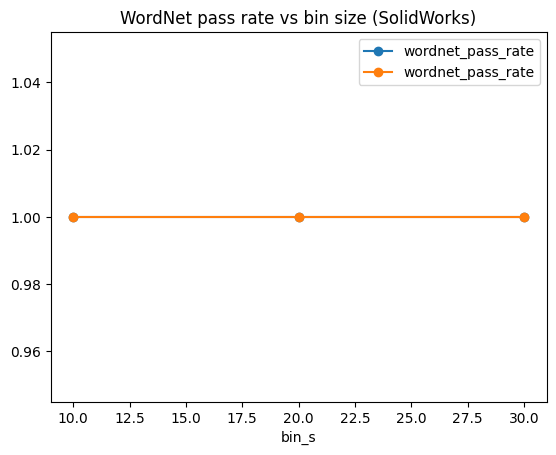

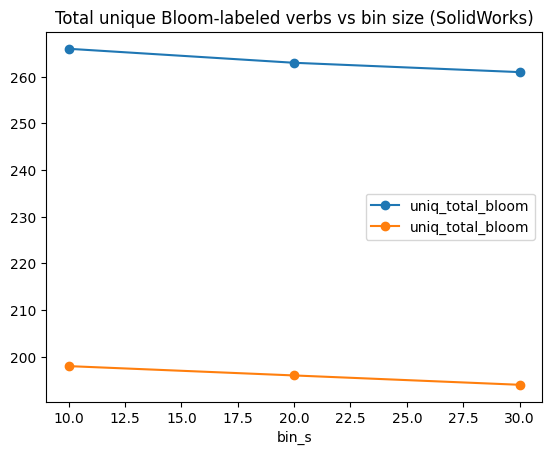

In [ ]:
# ===== 9) Optional plots: WordNet pass rate + unique Bloom counts =====
import matplotlib.pyplot as plt
import pandas as pd

# Requires cmp from previous cell
if "cmp" not in globals():
    raise RuntimeError("Run comparison cell first.")

# WordNet pass rate plot
ax = None
for exp in sorted(cmp["experiment"].unique()):
    sub = cmp[cmp["experiment"]==exp].sort_values("bin_s")
    ax = sub.plot(x="bin_s", y="wordnet_pass_rate", marker="o", title=f"WordNet pass rate vs bin size ({exp})", ax=ax)
plt.show()

# Unique Bloom counts plot (sum of uniq_* across labels)
cmp2 = cmp.copy()
cmp2["uniq_total_bloom"] = cmp2[[f"uniq_{lab}" for lab in LABELS]].sum(axis=1)

ax = None
for exp in sorted(cmp2["experiment"].unique()):
    sub = cmp2[cmp2["experiment"]==exp].sort_values("bin_s")
    ax = sub.plot(x="bin_s", y="uniq_total_bloom", marker="o", title=f"Total unique Bloom-labeled verbs vs bin size ({exp})", ax=ax)
plt.show()


## Normalized time vs 20 s bins (what we do and why)

### 1) Raw binning (fixed 20 s)
Whisper outputs one row per **fixed-width** bin of duration \(\Delta = 20\,\text{s}\).  
For participant \(p\), experiment \(e\), bin \(i\):

- start time: \(s_{p,e,i}\)
- midpoint time: \(t_{p,e,i} = s_{p,e,i} + \Delta/2\)
- Bloom-domain counts in that bin: \(c_{p,e,i,\ell}\) for domain \(\ell\in\{Kn,Cm,Ap,An,Ev,Sn\}\)

If a session lasts \(T\) seconds, it has roughly \(\lceil T/\Delta \rceil\) bins (so different sessions can have different bin counts).

### 2) Why normalization is needed
Sessions have different durations (e.g., 200 s vs 300 s).  
To compare *early/middle/late* behavior fairly, we use **dimensionless progress**:

\[
\tau_{p,e,i} = \frac{t_{p,e,i}}{T_{p,e}} \in [0,1)
\]

where \(T_{p,e}\) is the session duration (estimated from the last bin end time, or last start + \(\Delta\)).

### 3) Progress-bin re-bucketing (dimensionless bins)
Choose \(N\) progress bins (e.g., \(N=25\)). Map each raw bin to a progress bin:

\[
k = \left\lfloor \tau_{p,e,i}\,N \right\rfloor,\quad k\in\{0,\dots,N-1\}
\]

Then aggregate the raw 20 s bins into progress bins:

\[
C_{p,e,k,\ell} = \sum_{i:\,k(i)=k} c_{p,e,i,\ell}
\]

After this step, the x-axis is **progress bin index** (dimensionless), not seconds.

### 4) Group aggregation (fair across durations)
For **per-bin histograms**, we compute the mean across participants:

\[
\bar{C}_{e,k,\ell} = \frac{1}{|P|}\sum_{p\in P} C_{p,e,k,\ell}
\]

We also **fill missing progress bins with 0 increments** so every participant has exactly \(N\) bins.

### 5) Correct cumulative curves (fix for “short vs long sessions”)
Cumulative must be computed **per participant first**, then averaged:

\[
S_{p,e,k,\ell} = \sum_{j=0}^{k} C_{p,e,j,\ell}
\]
\[
\bar{S}_{e,k,\ell} = \frac{1}{|P|}\sum_{p\in P} S_{p,e,k,\ell}
\]

This is important: **do not** take the group mean of increments and then cumulatively sum it (that can bias the curve when sessions have different lengths / bin mappings).

### 6) Histogram readability
Counts are sparse (many bins have zeros). For readability, the notebook supports:
- **Heatmap** (domains × bins) with cell annotations (best for interpretation), and
- **Histogram** bars that optionally **drop empty bins** (best for bar-style viewing).


,participant_raw,participant
0,P01,P01
372,P02,P02
467,P03,P03
499,P04,P04
565,P05,P05
605,P06,P06
628,P07,P07
688,P08,P08
740,P09,P09
77,P10,P10


,participant,experiment,pbin,bocc_primary_Kn,bocc_primary_Cm,bocc_primary_Ap,bocc_primary_An,bocc_primary_Sn,bocc_primary_Ev
0,P01,AR-CAD,0,1.0,1.0,2.0,0.0,0.0,0.0
1,P01,AR-CAD,1,2.0,2.0,3.0,0.0,0.0,0.0
2,P01,AR-CAD,2,0.0,0.0,0.0,0.0,0.0,0.0
3,P01,AR-CAD,3,2.0,0.0,2.0,1.0,0.0,1.0
4,P01,AR-CAD,4,1.0,1.0,0.0,1.0,0.0,0.0
5,P01,AR-CAD,5,0.0,0.0,0.0,0.0,0.0,0.0
6,P01,AR-CAD,6,2.0,0.0,1.0,0.0,1.0,2.0
7,P01,AR-CAD,7,0.0,0.0,1.0,0.0,0.0,0.0
8,P01,AR-CAD,8,0.0,1.0,0.0,0.0,1.0,0.0
9,P01,AR-CAD,9,2.0,0.0,2.0,0.0,1.0,1.0


Saved plot table: D:\Thesis\Participants Data TRanscriptions\Participants Data\results\plot_table_bin20s_normalized_bocc_primary_MICROHIST_FIXED.csv


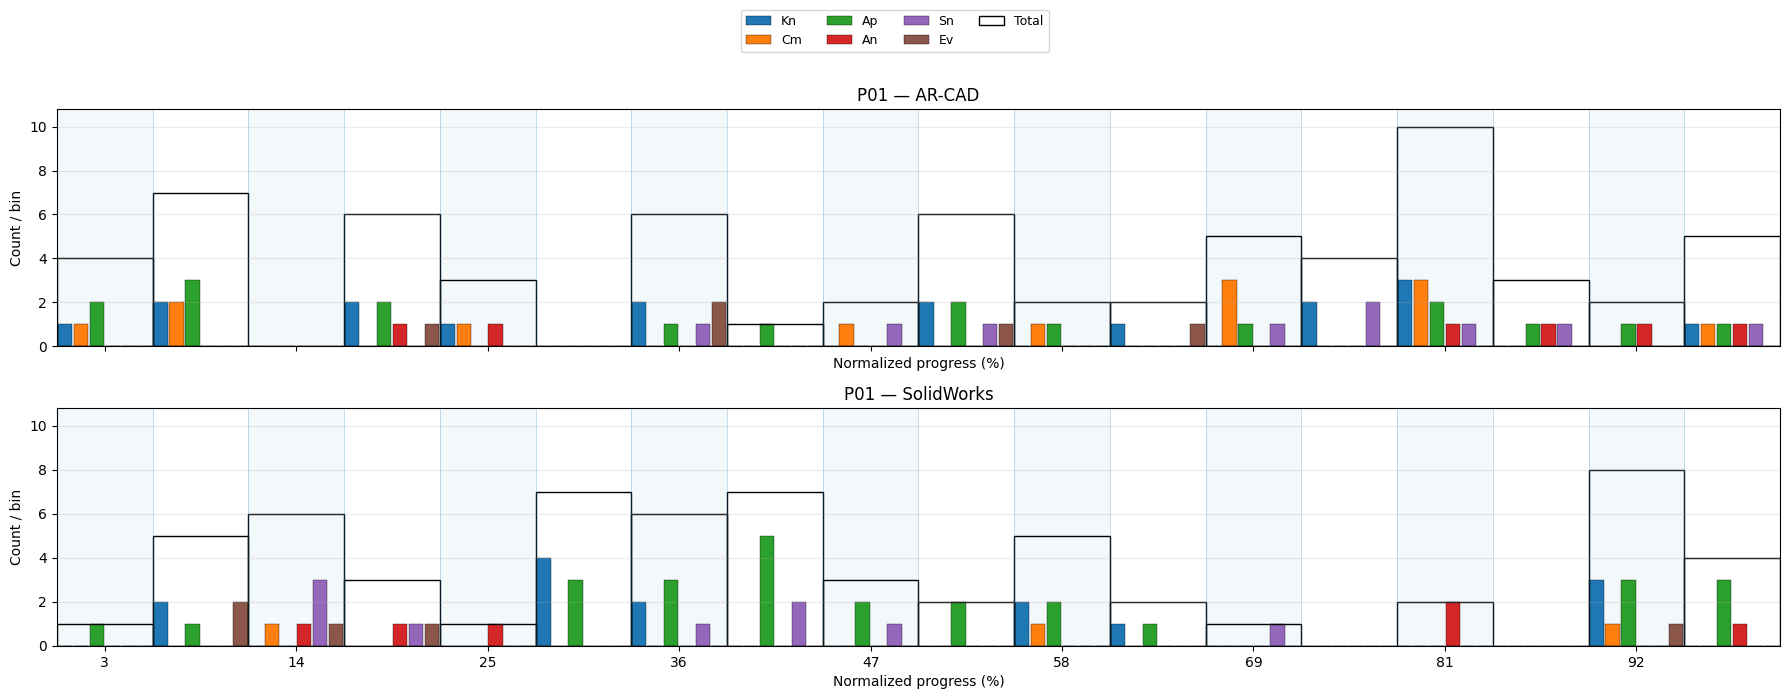

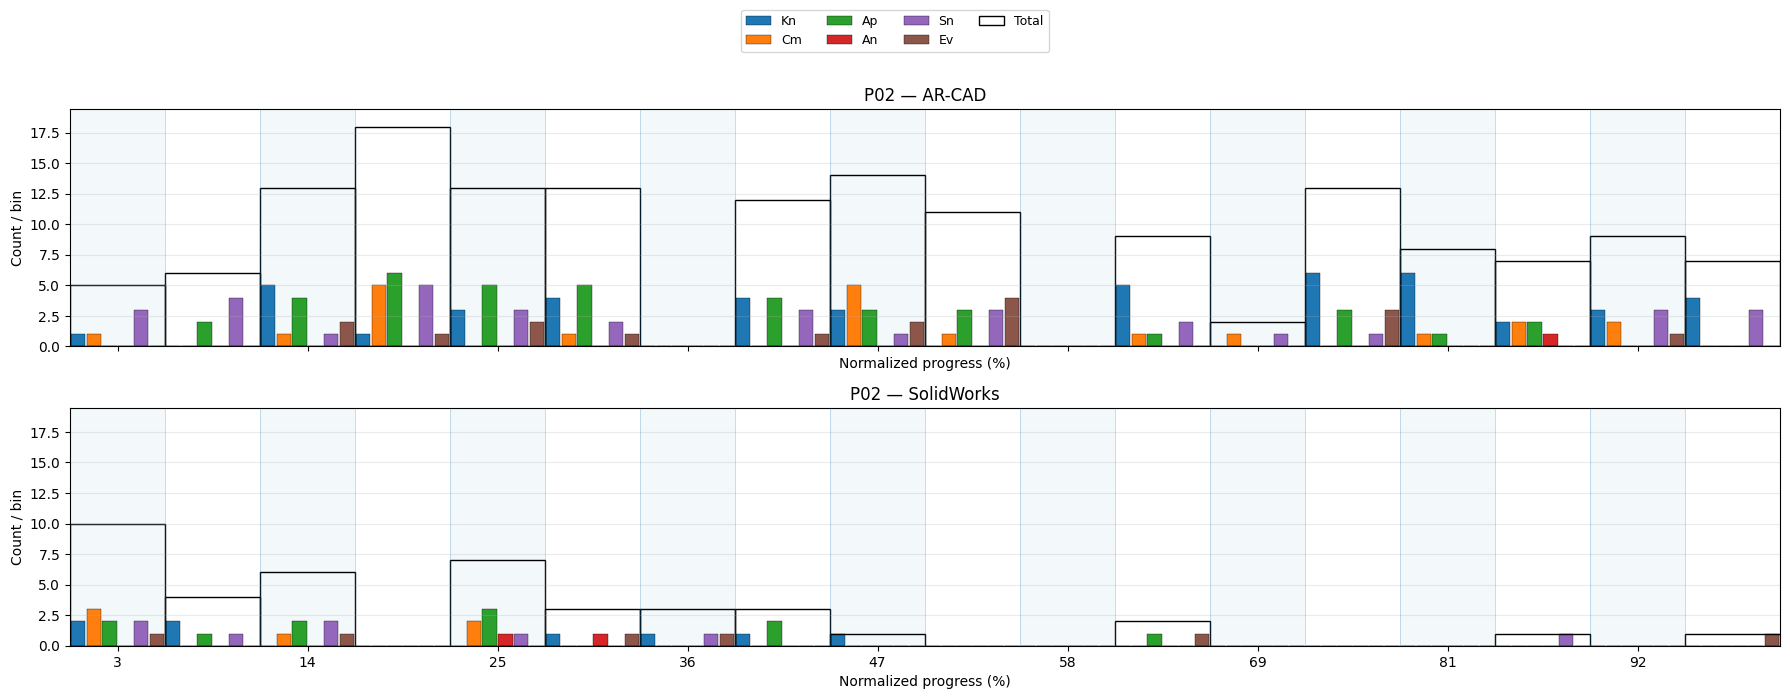

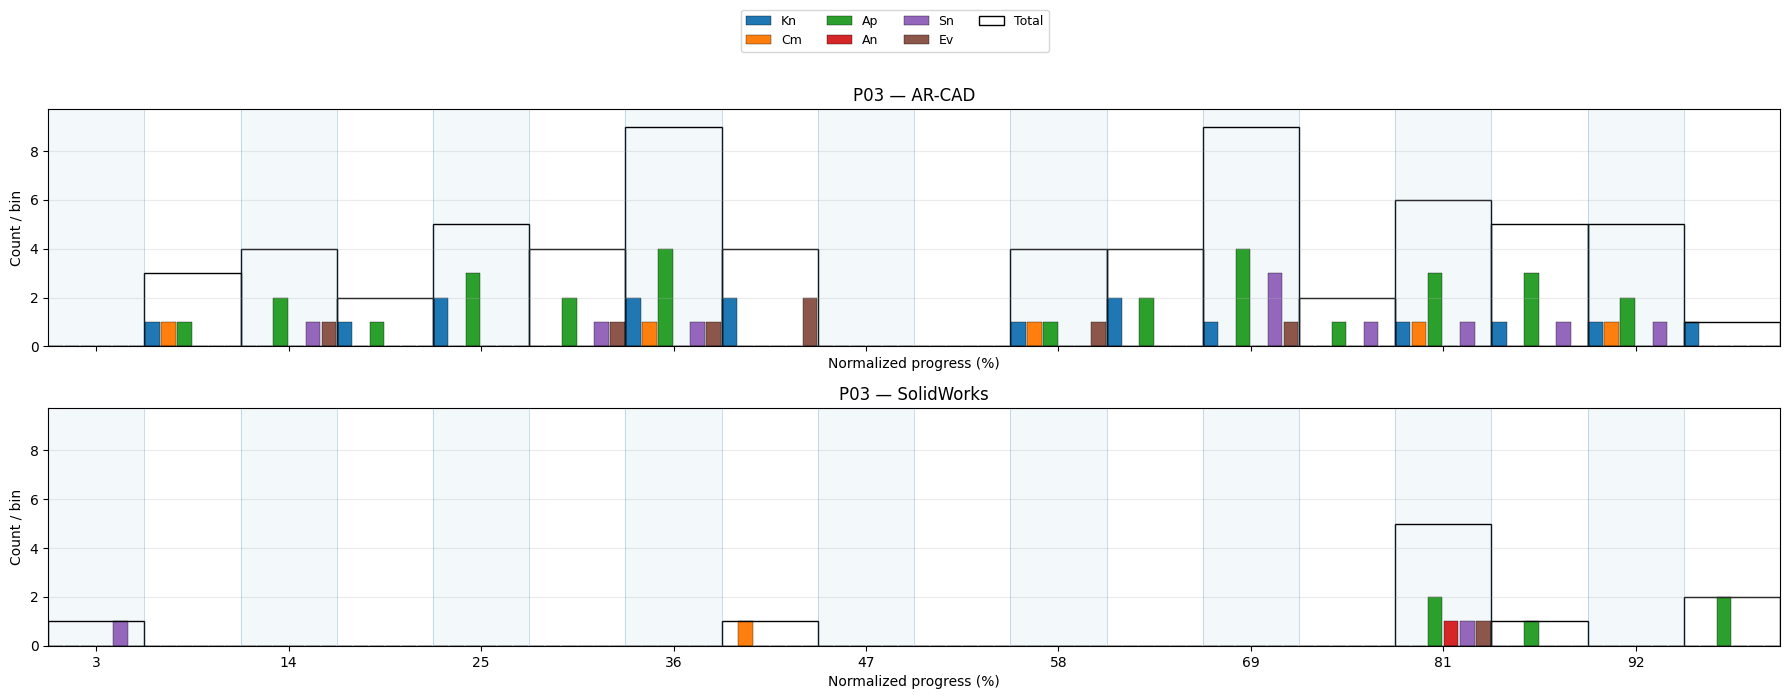

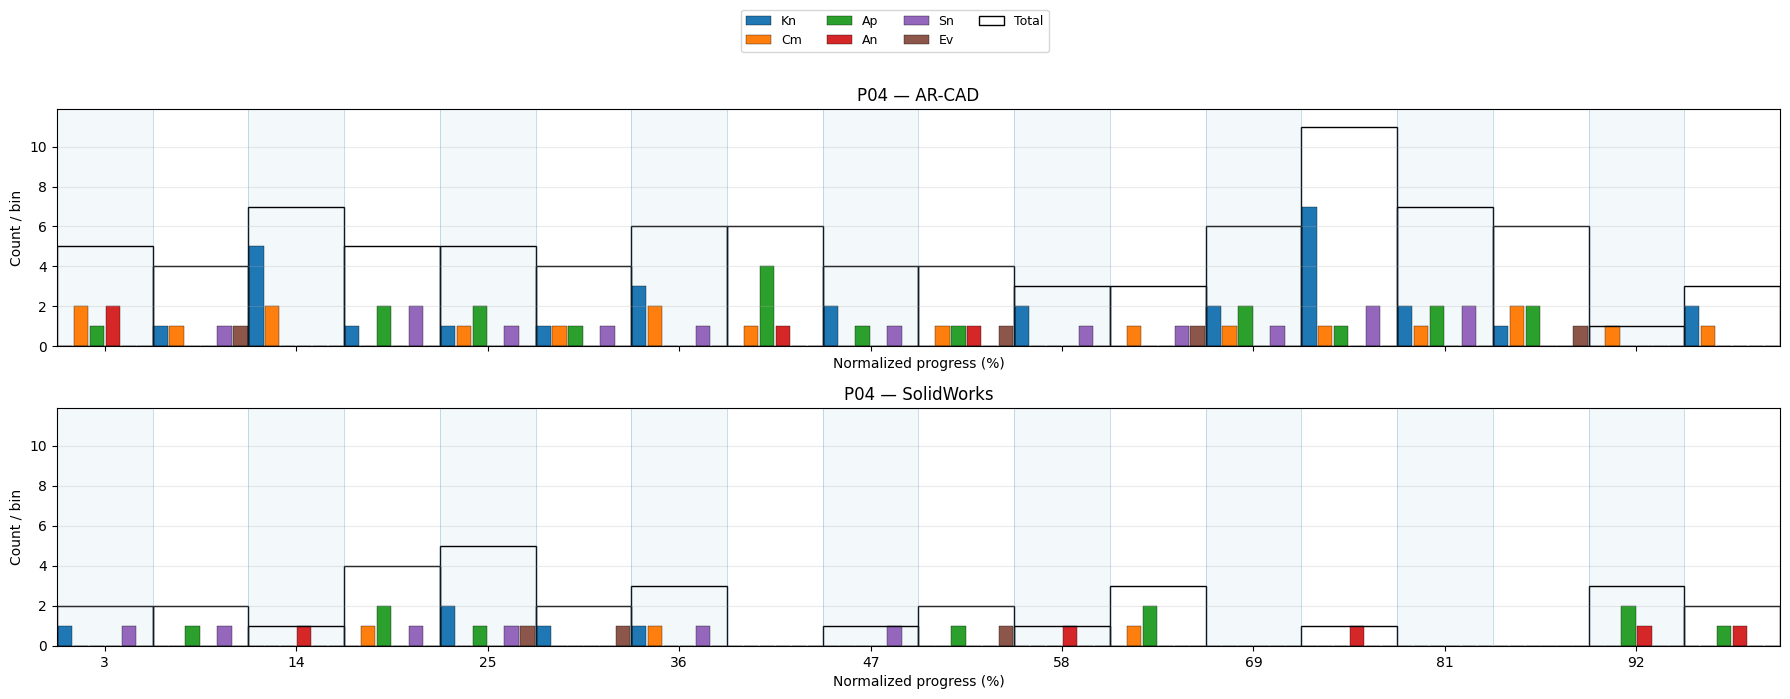

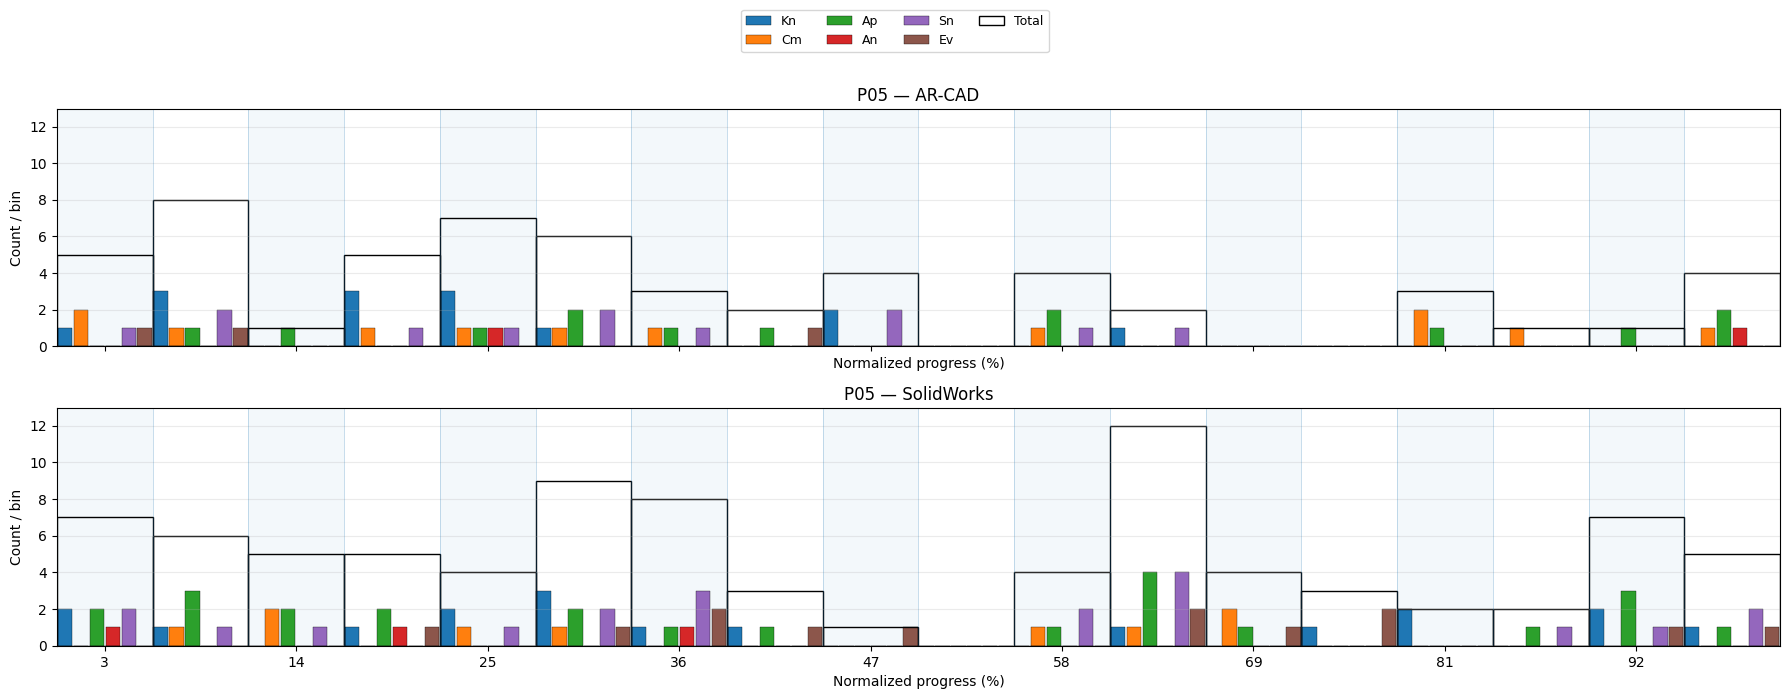

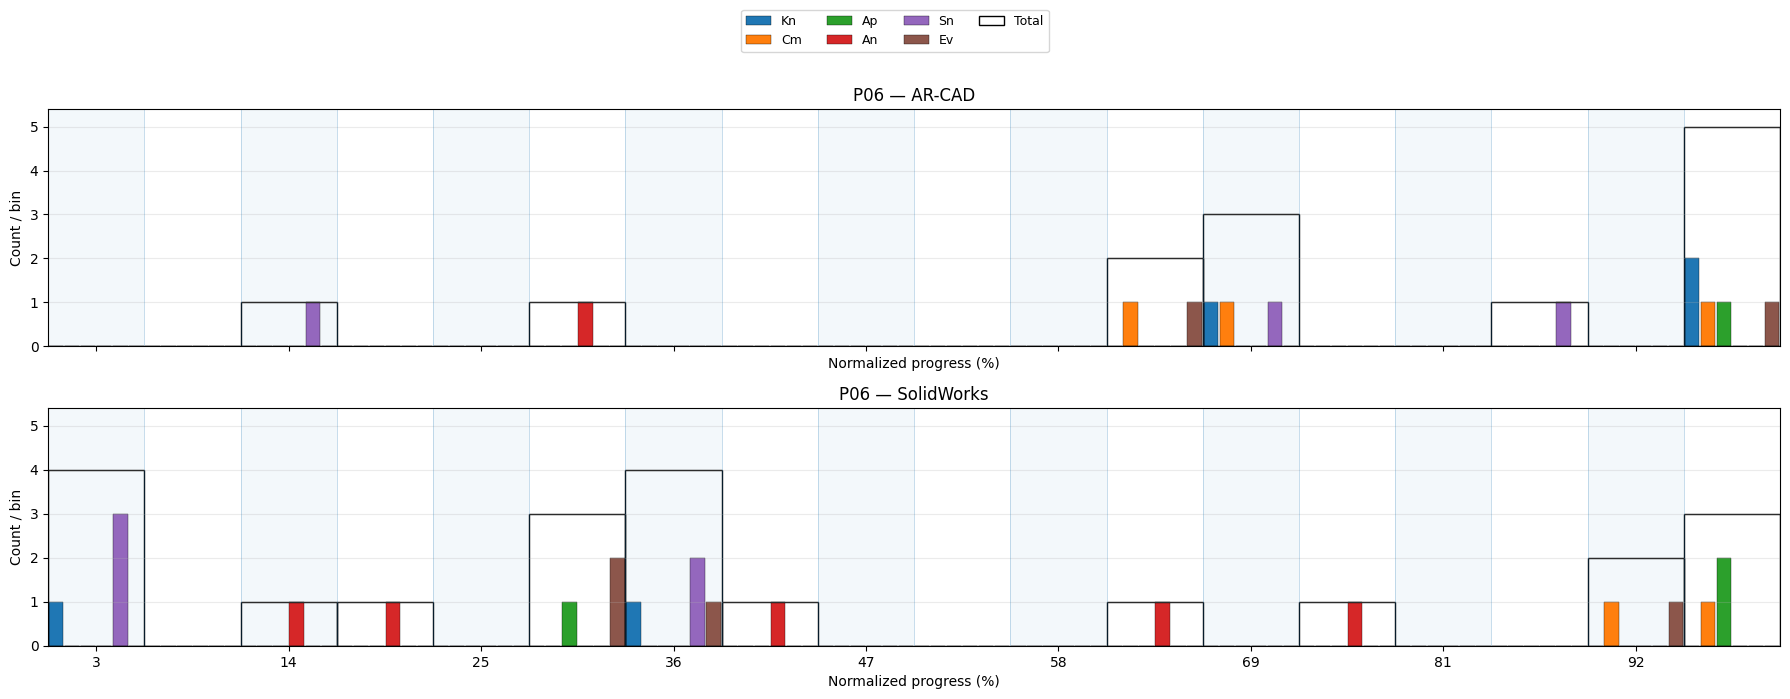

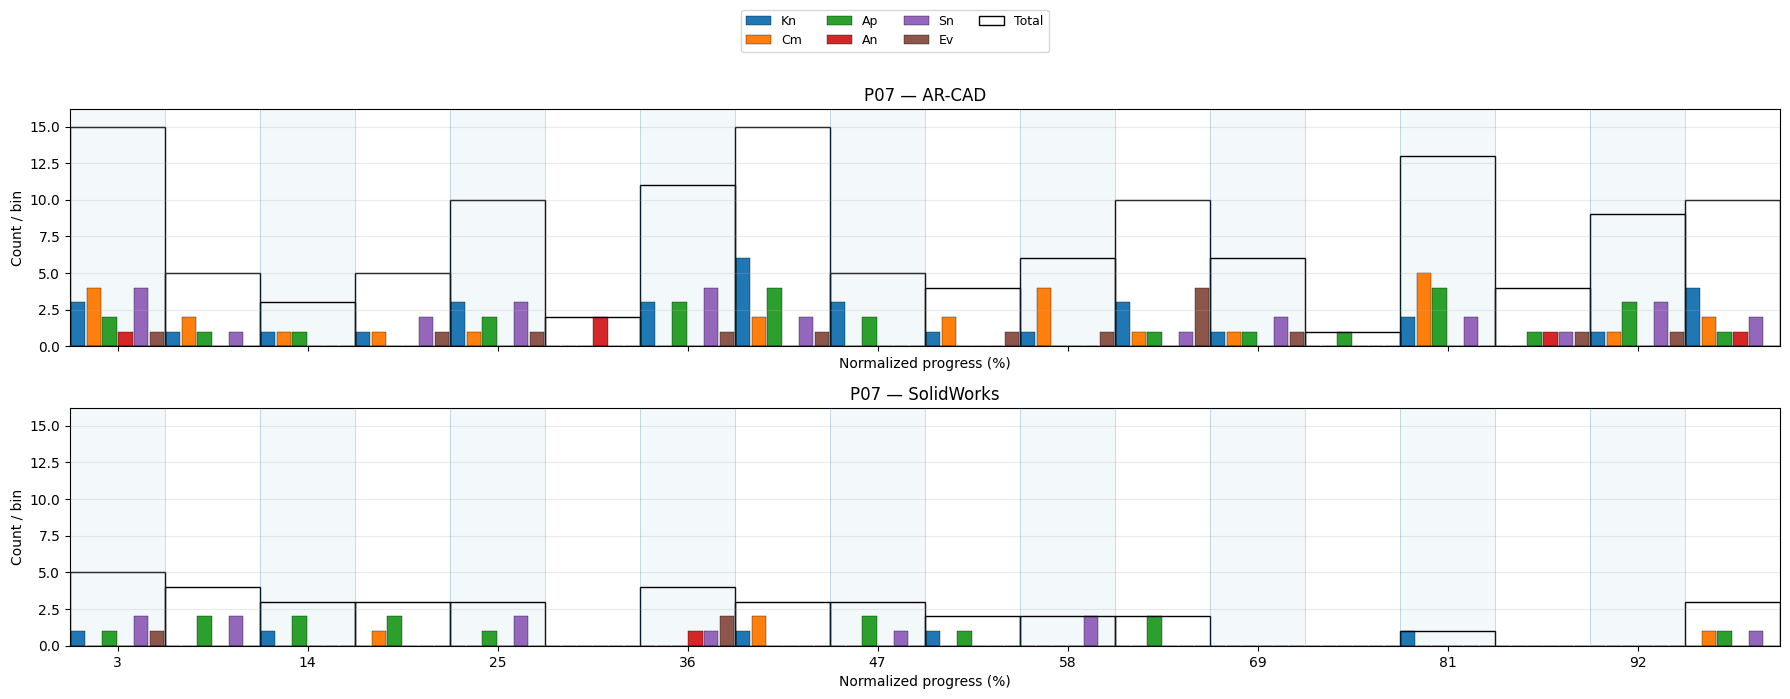

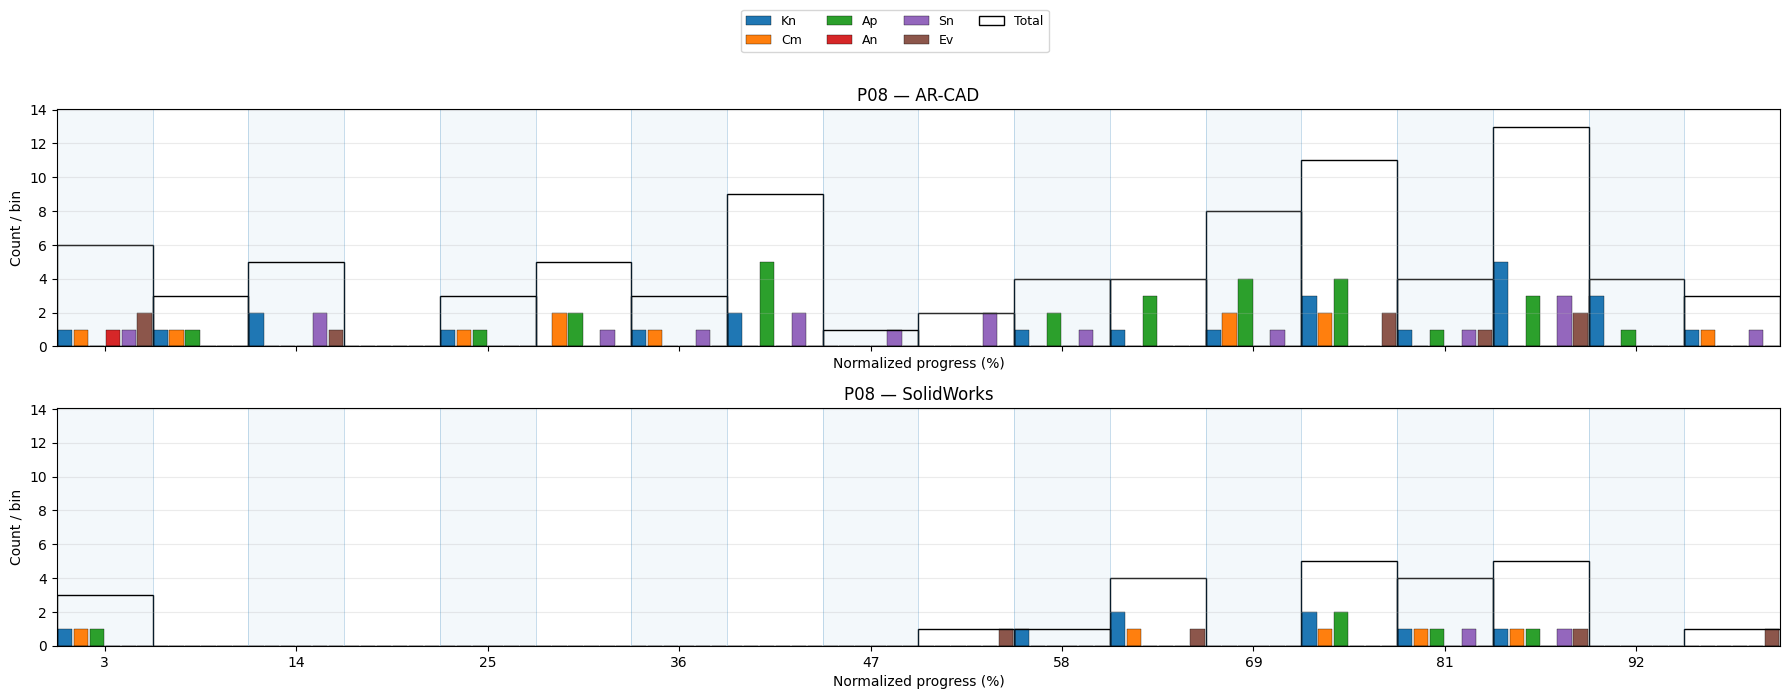

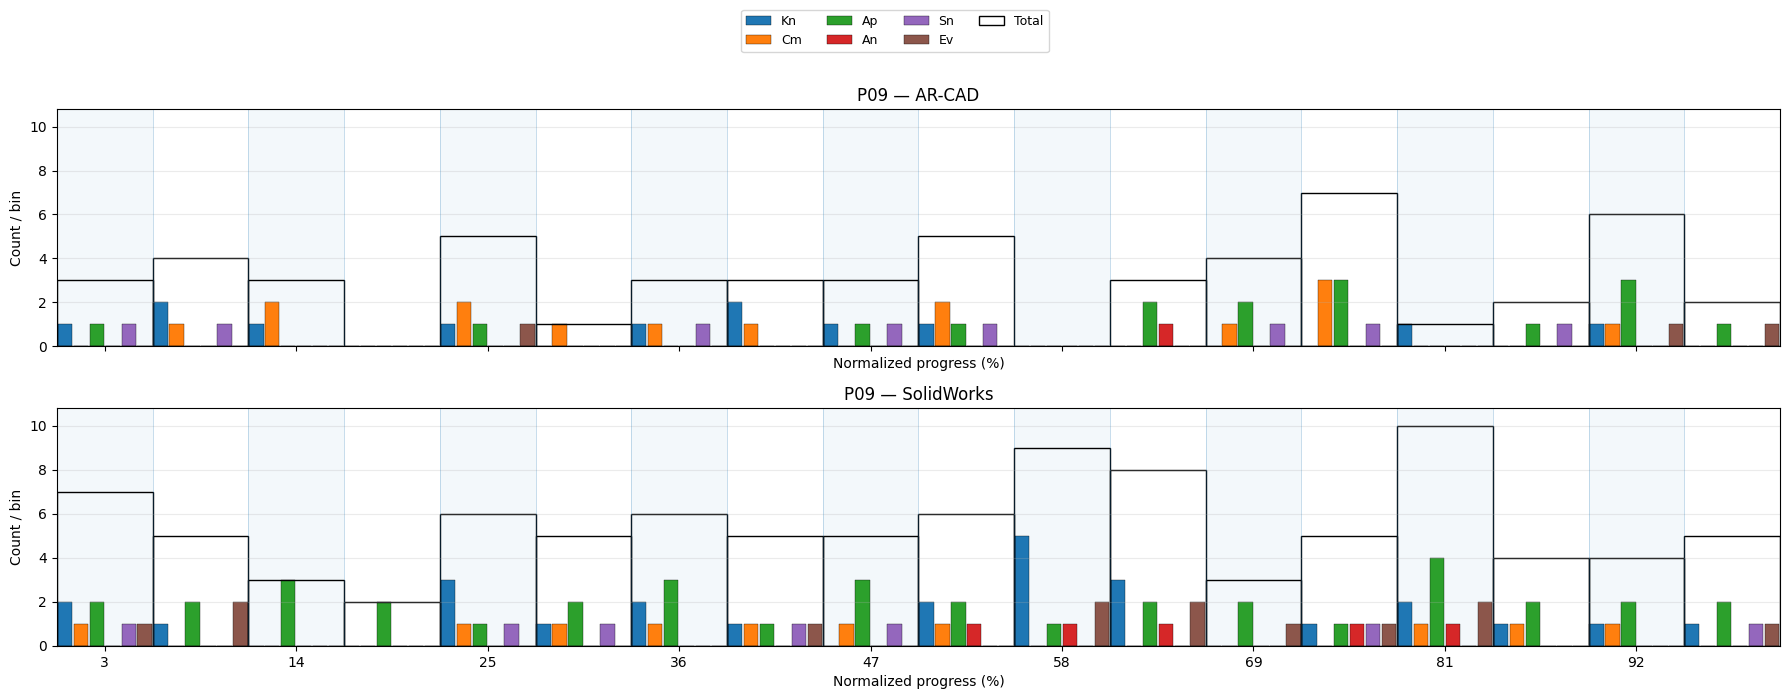

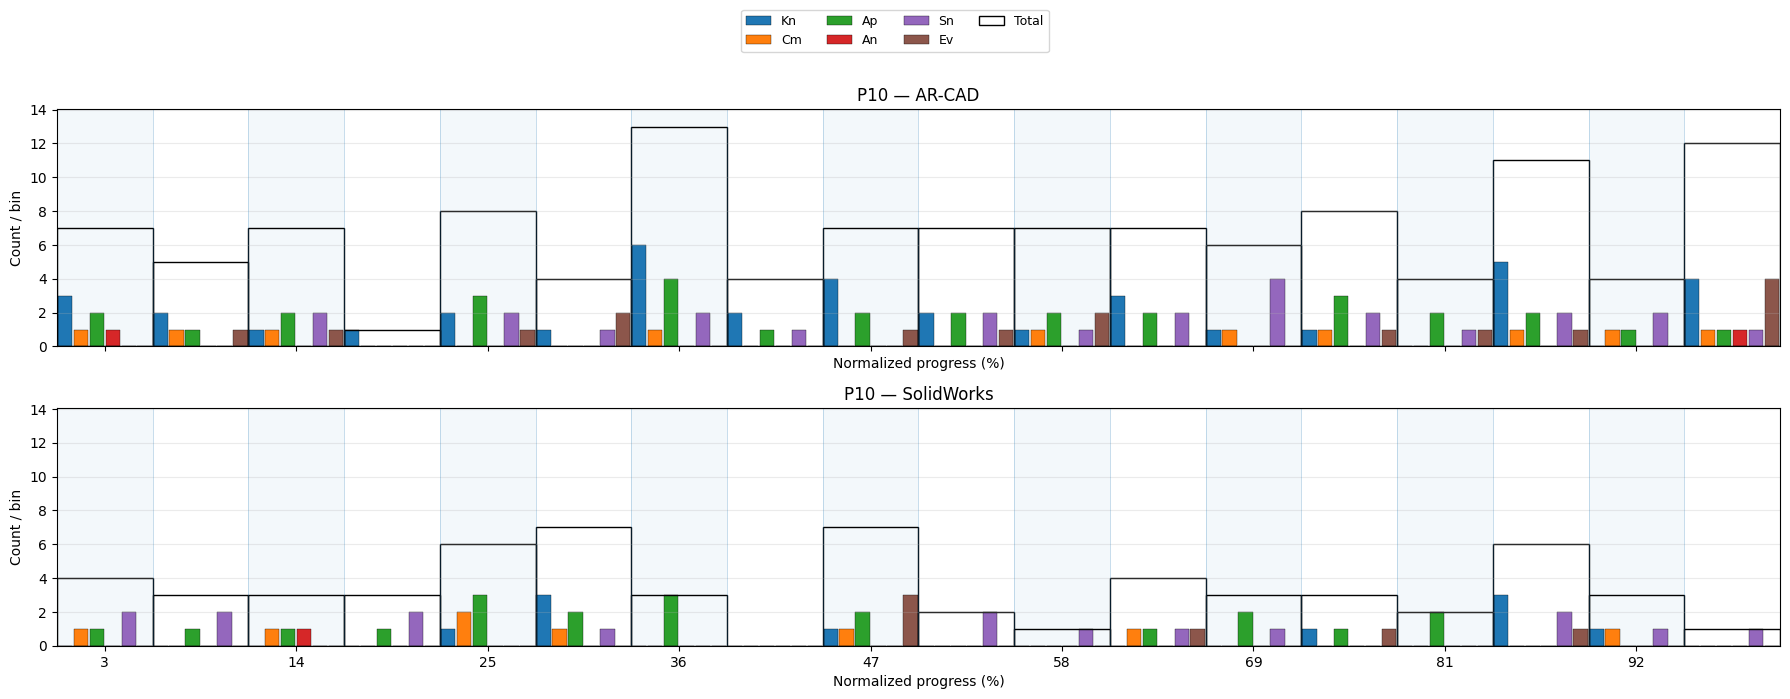

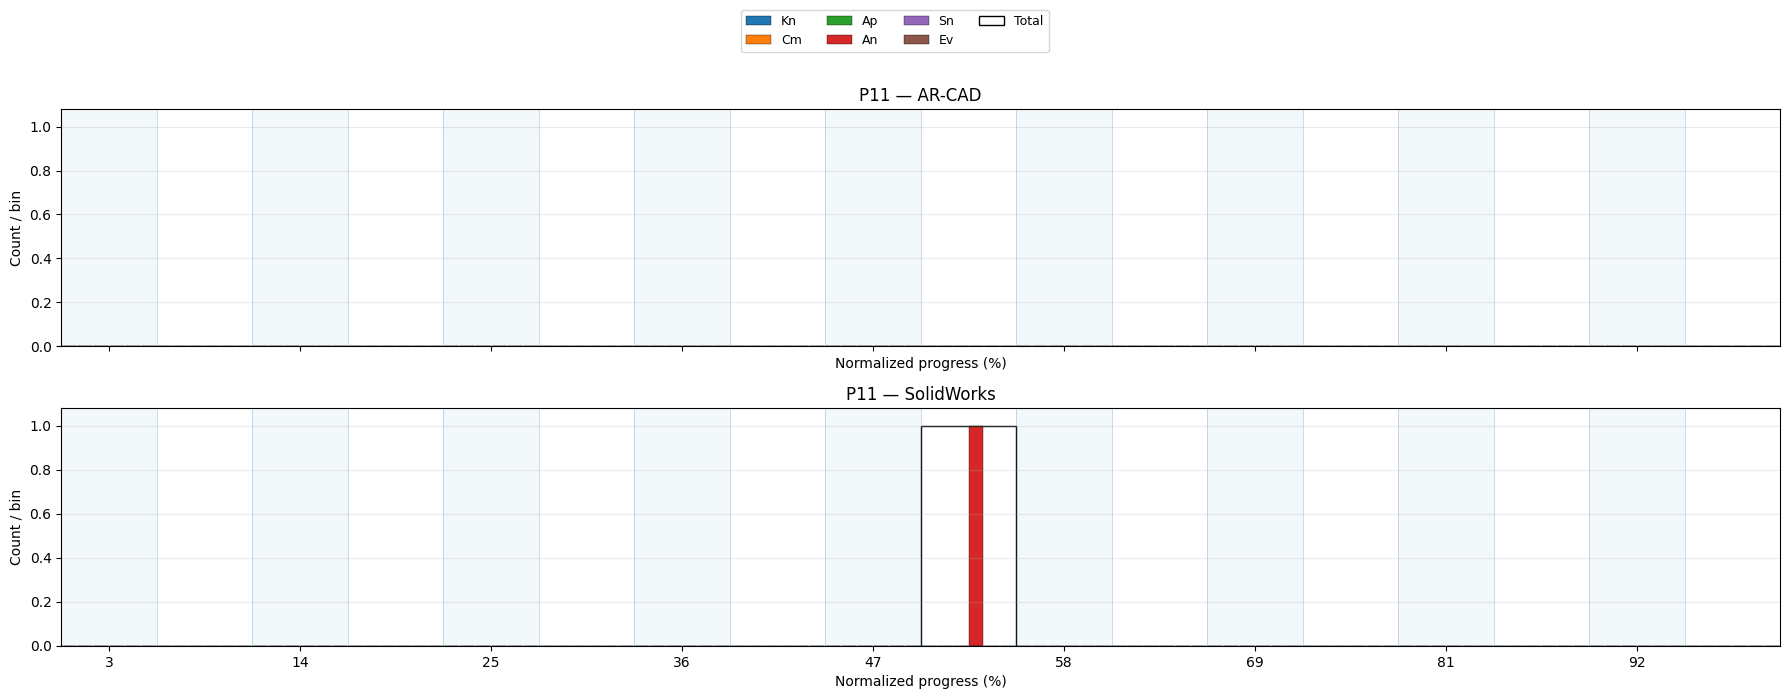

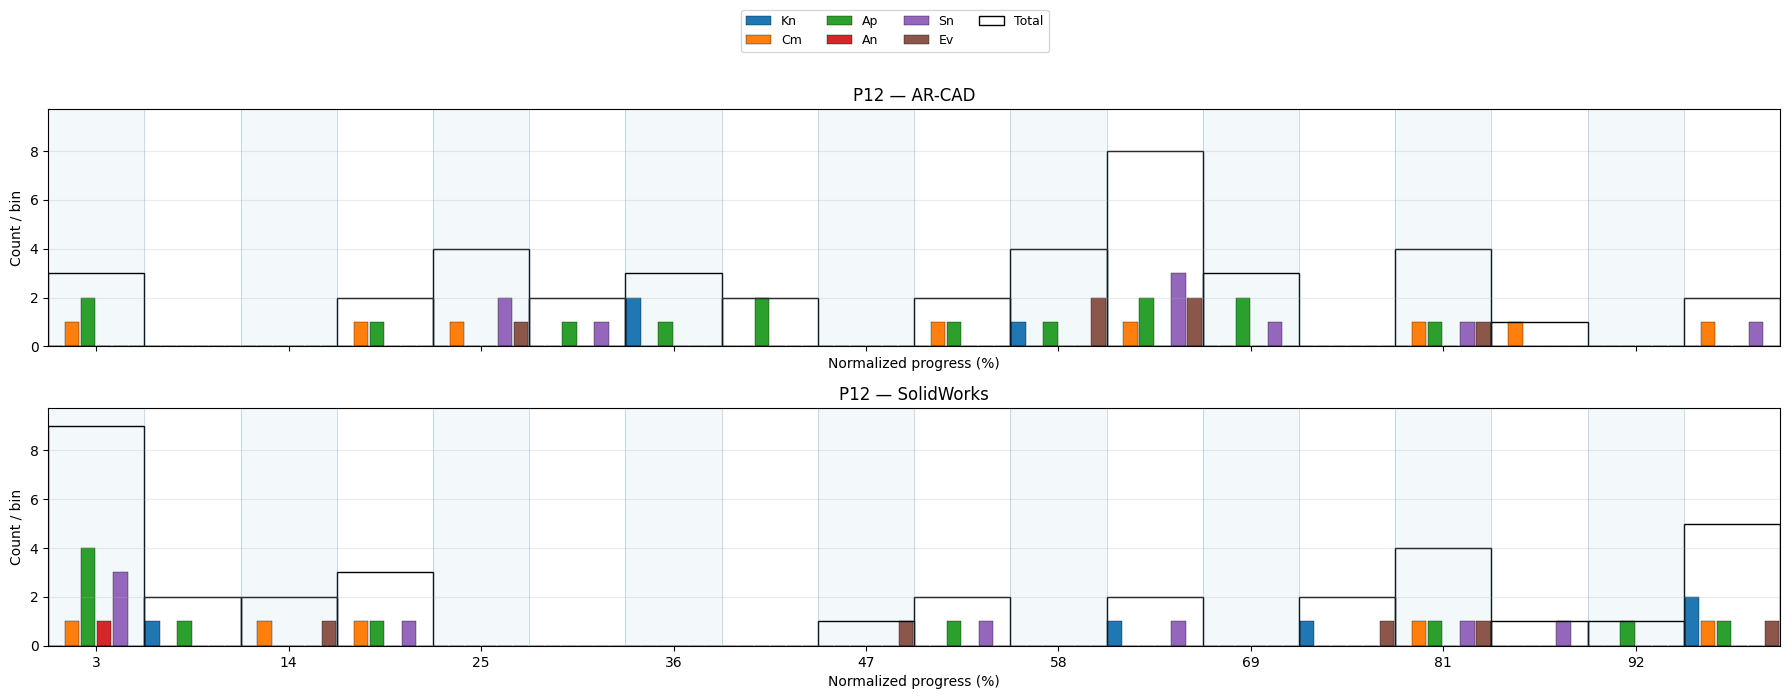

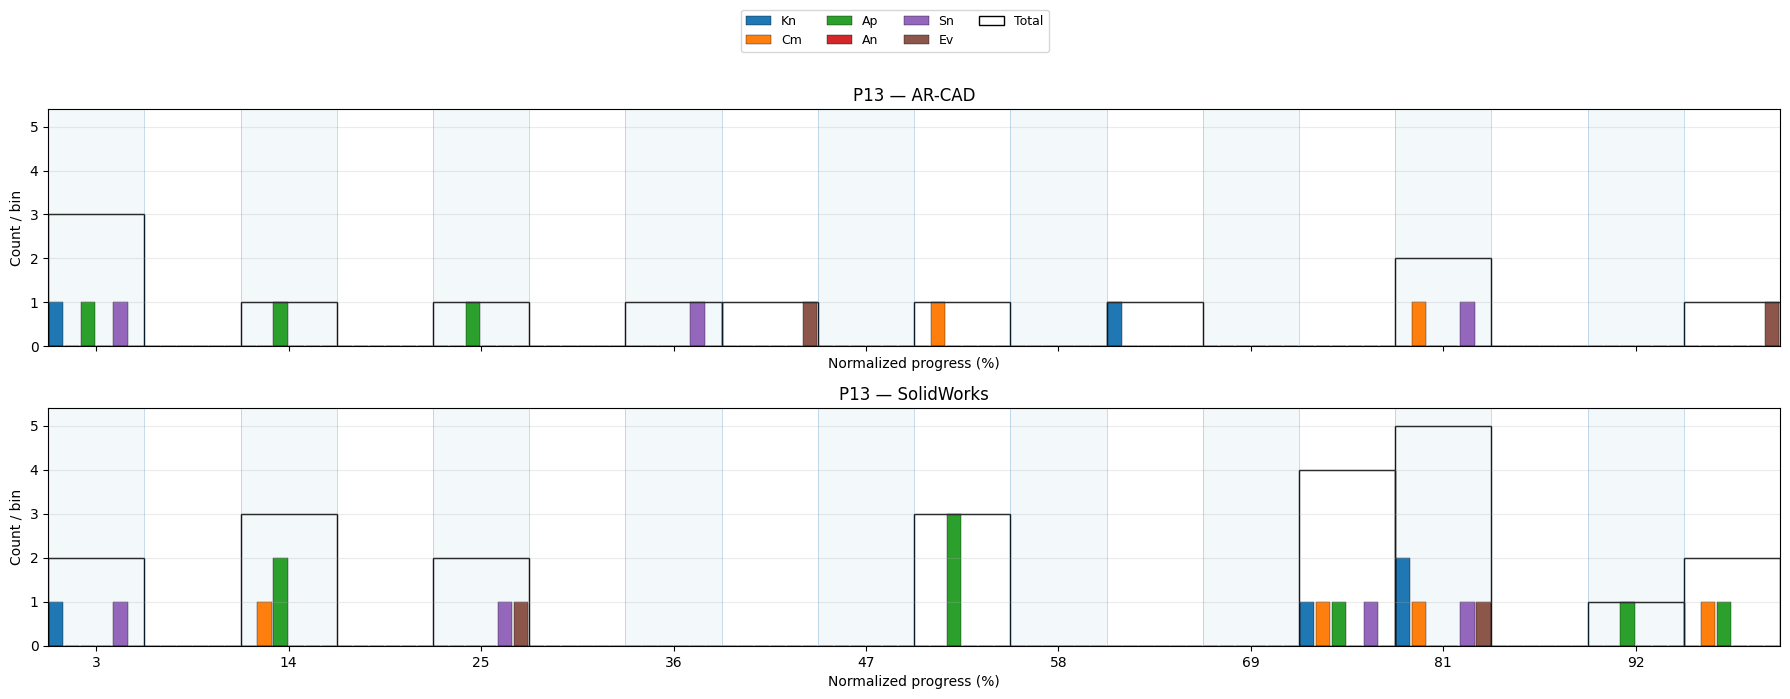

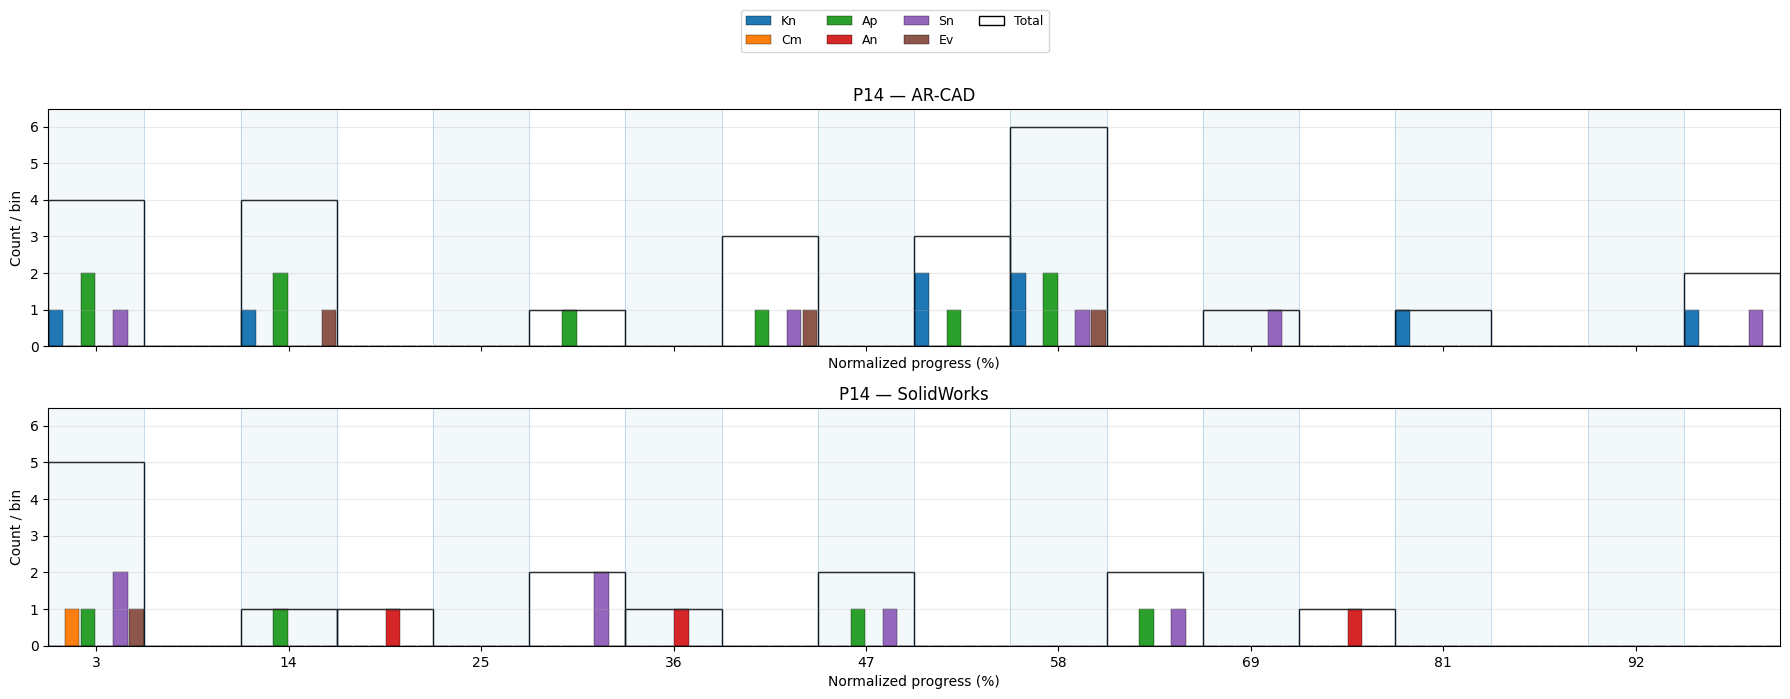

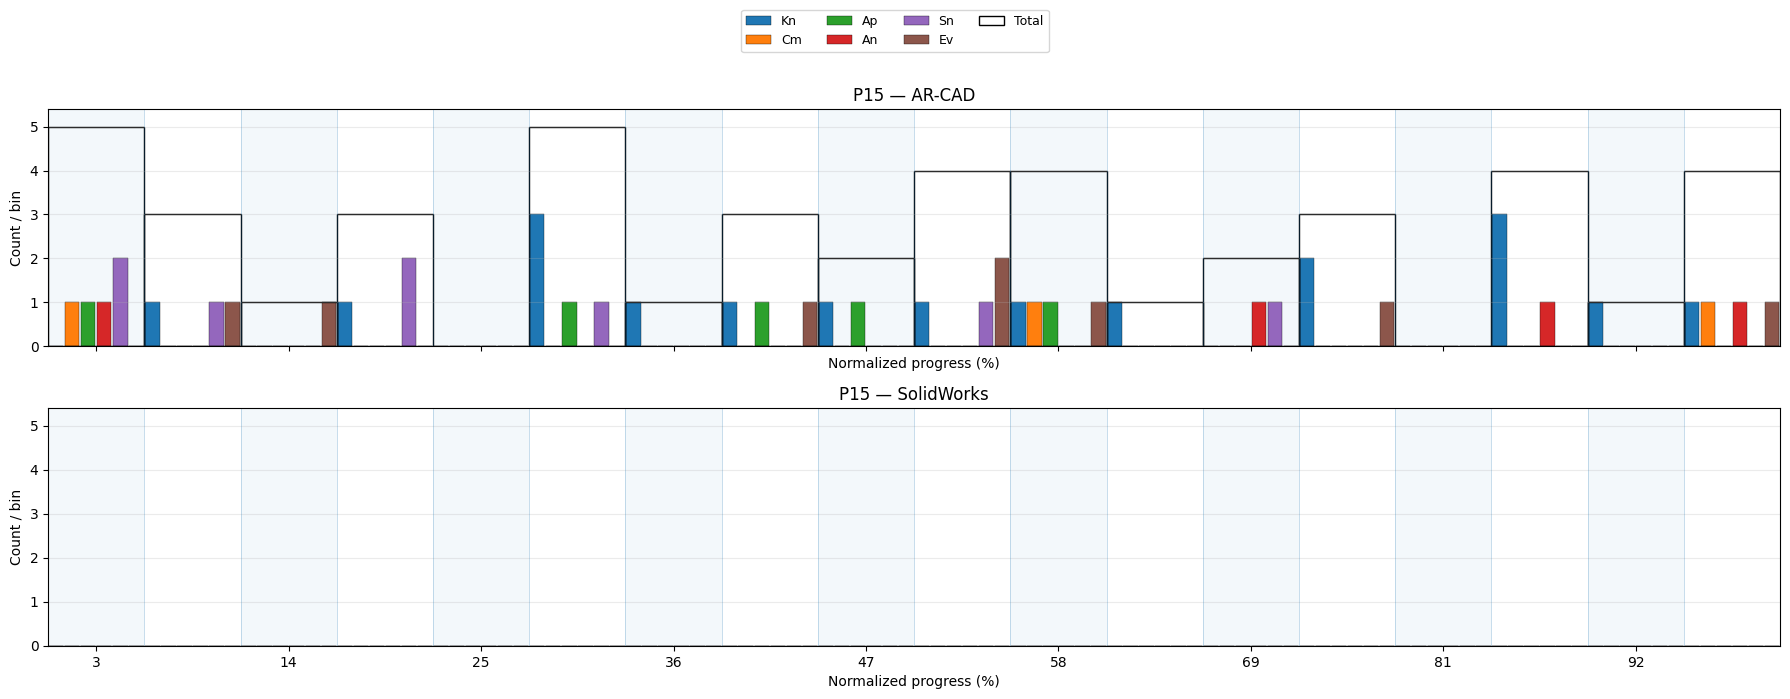

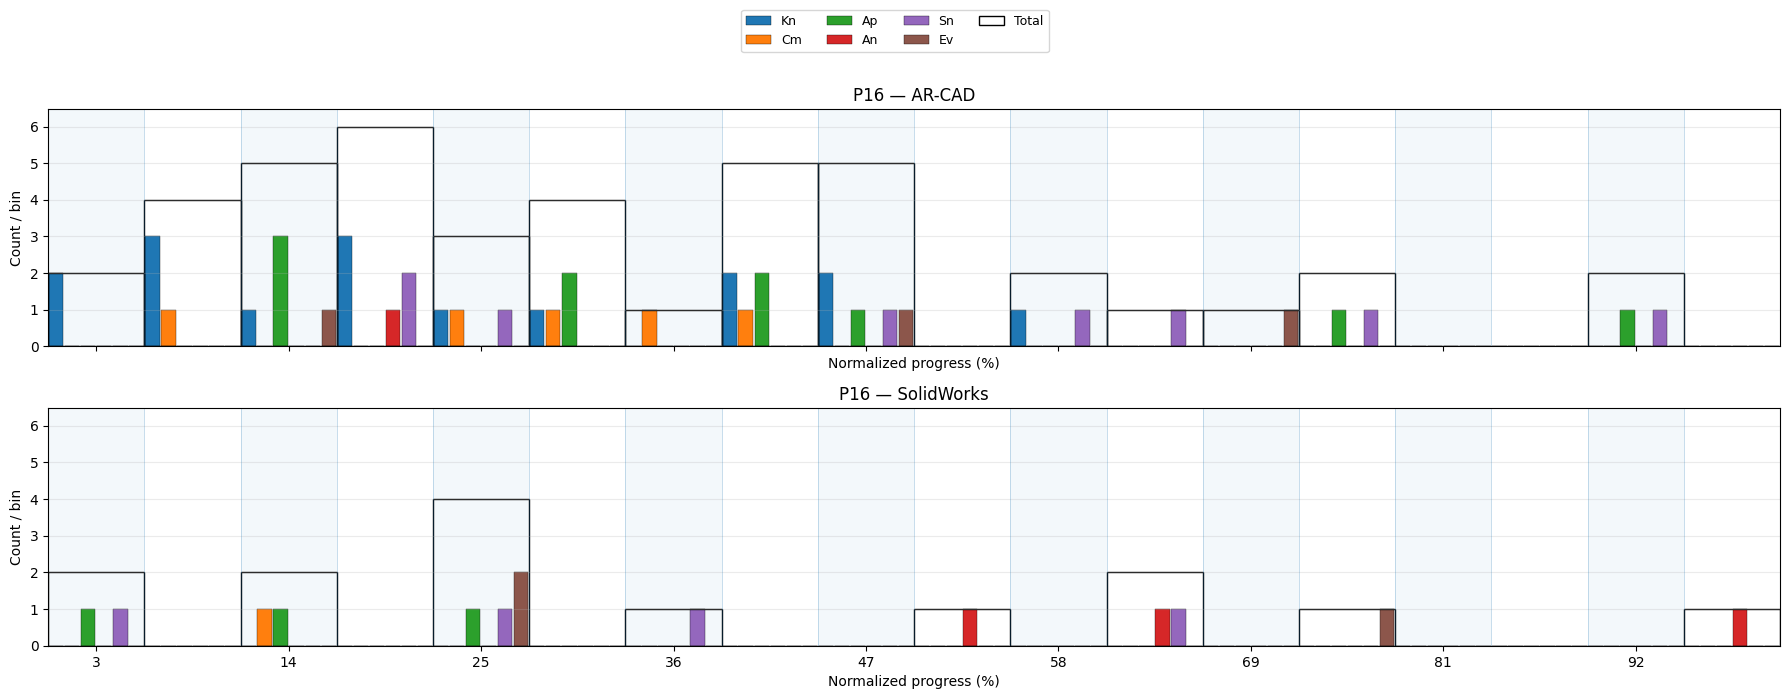

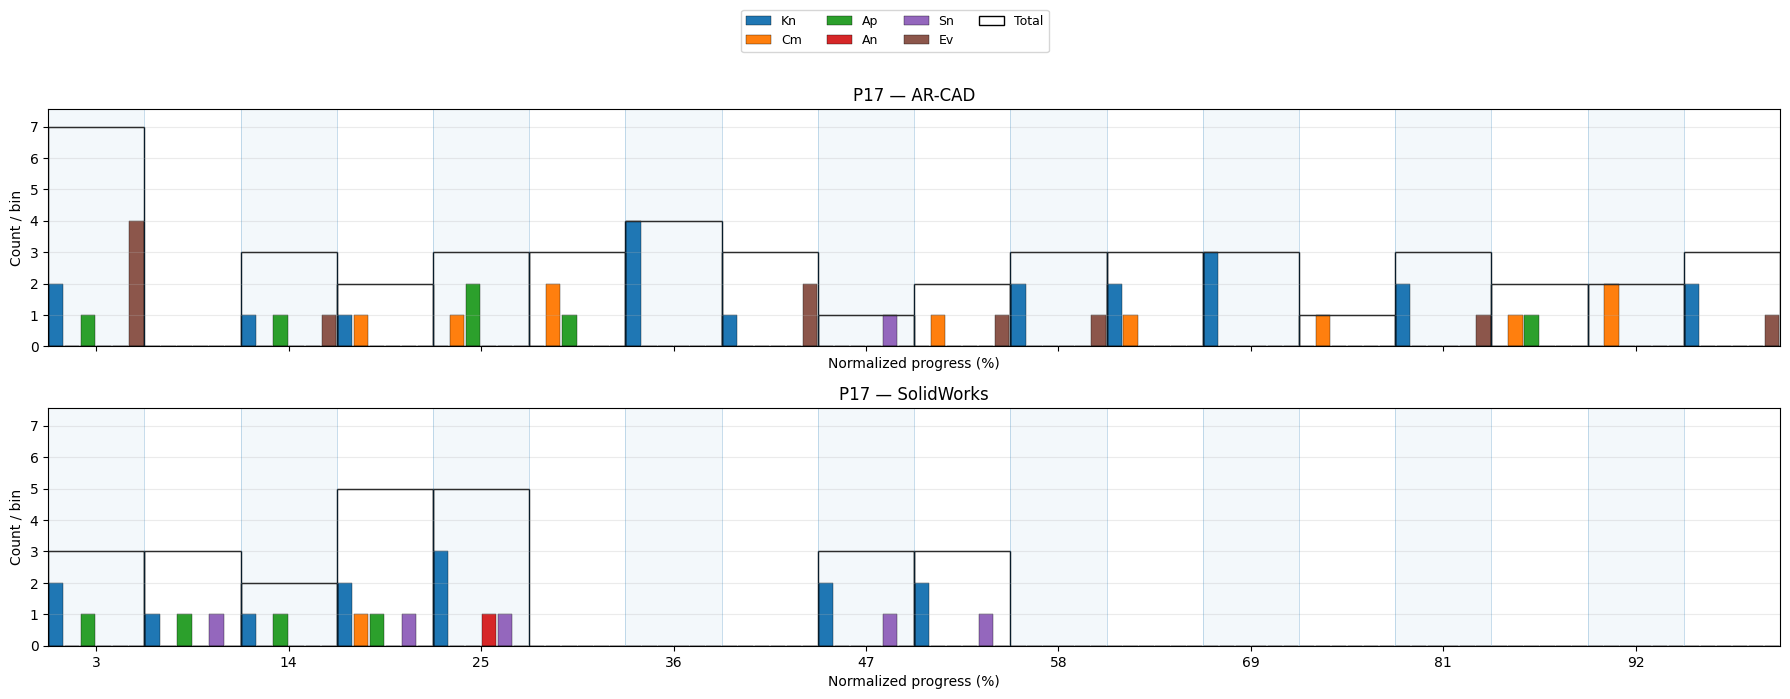

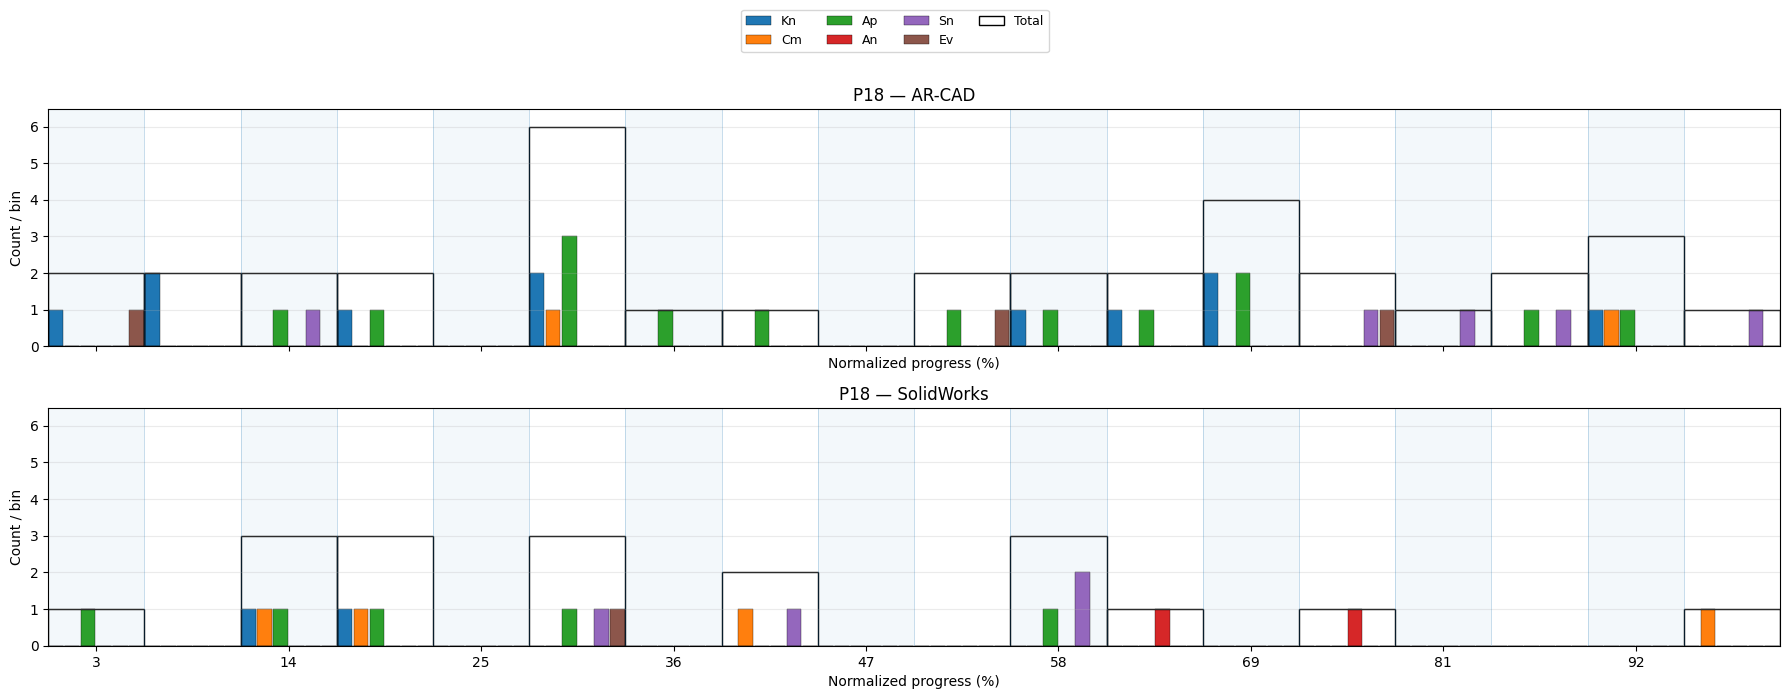

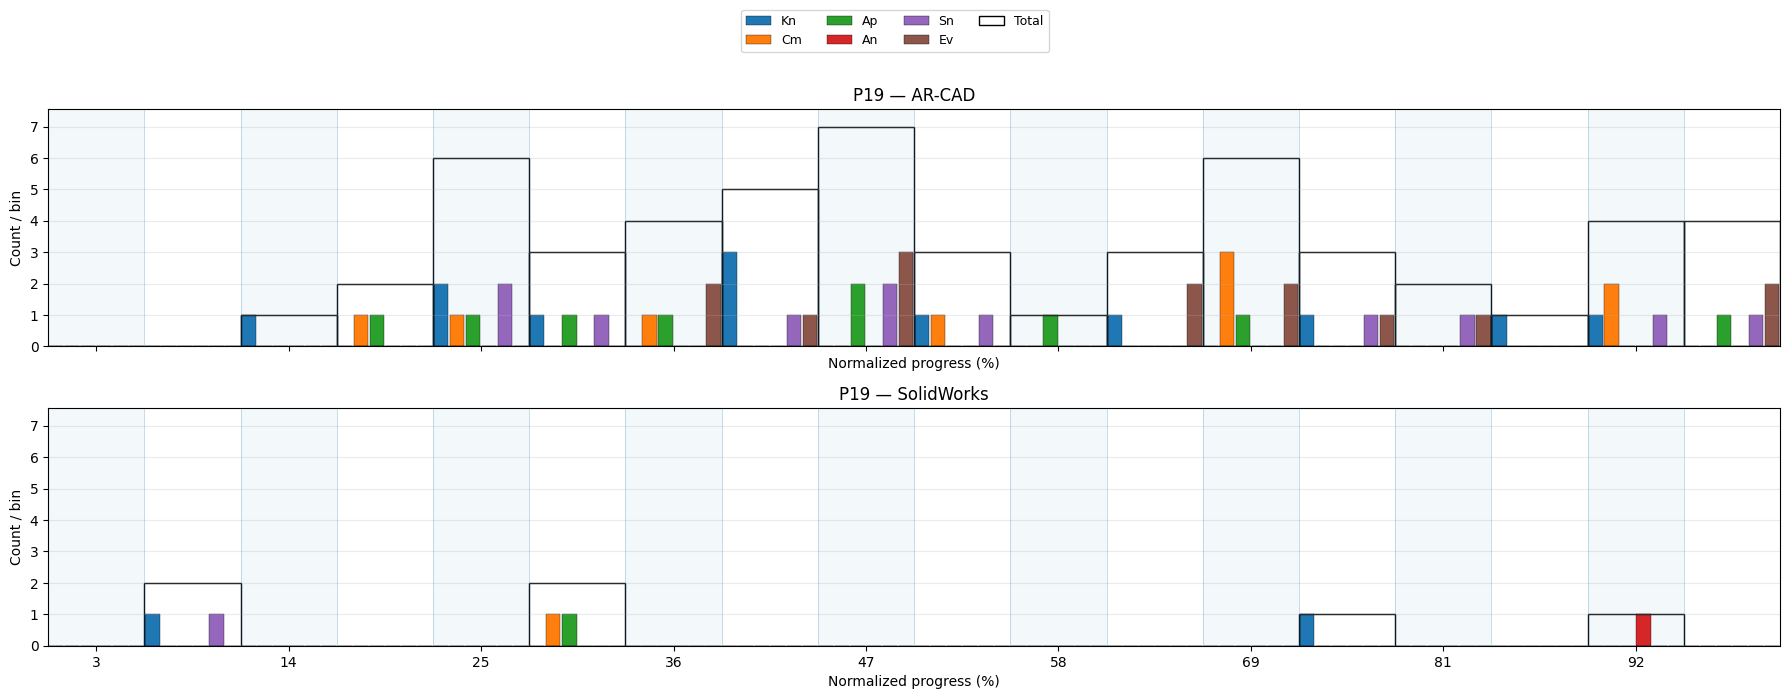

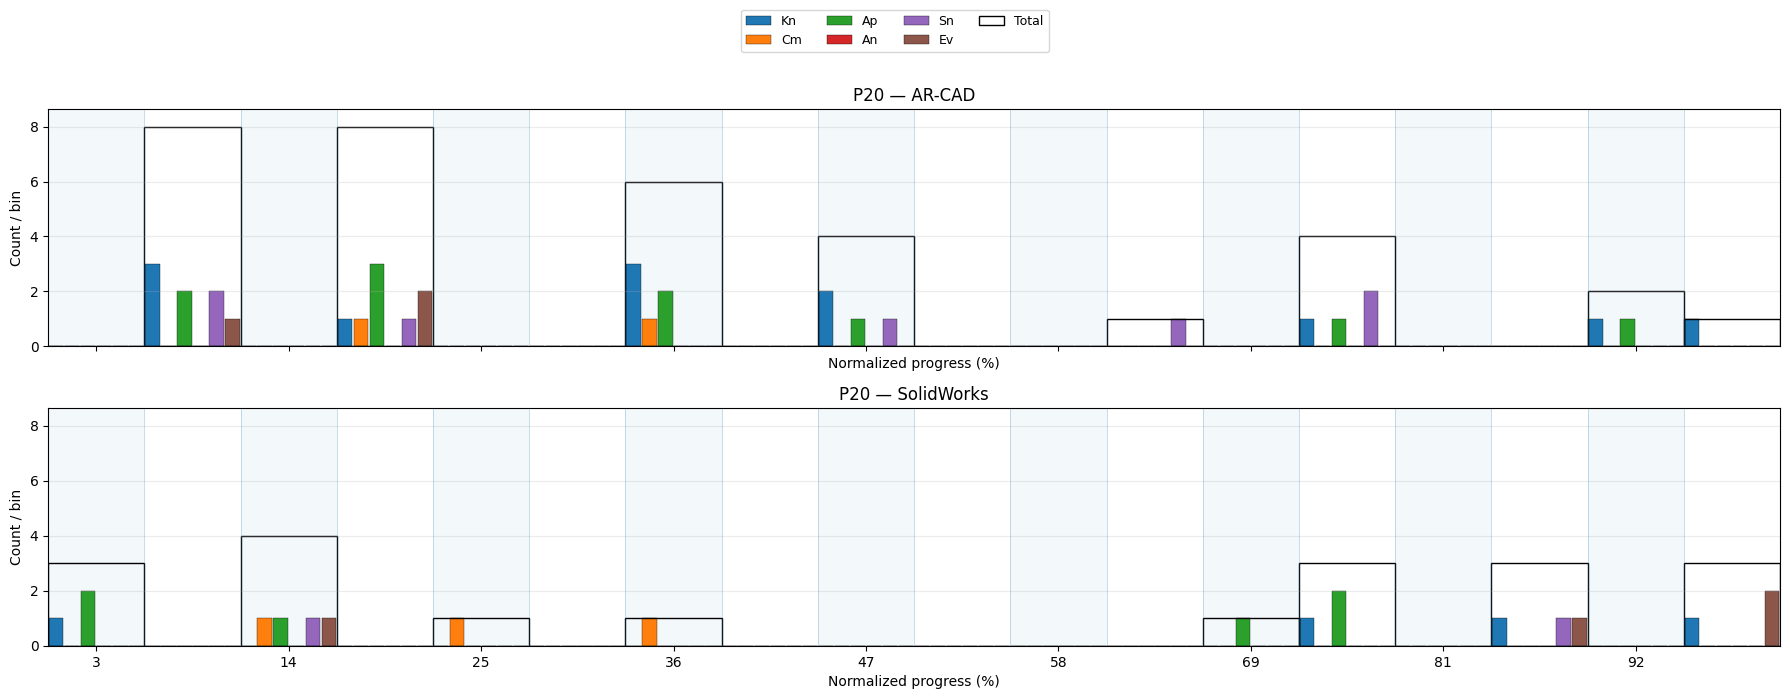

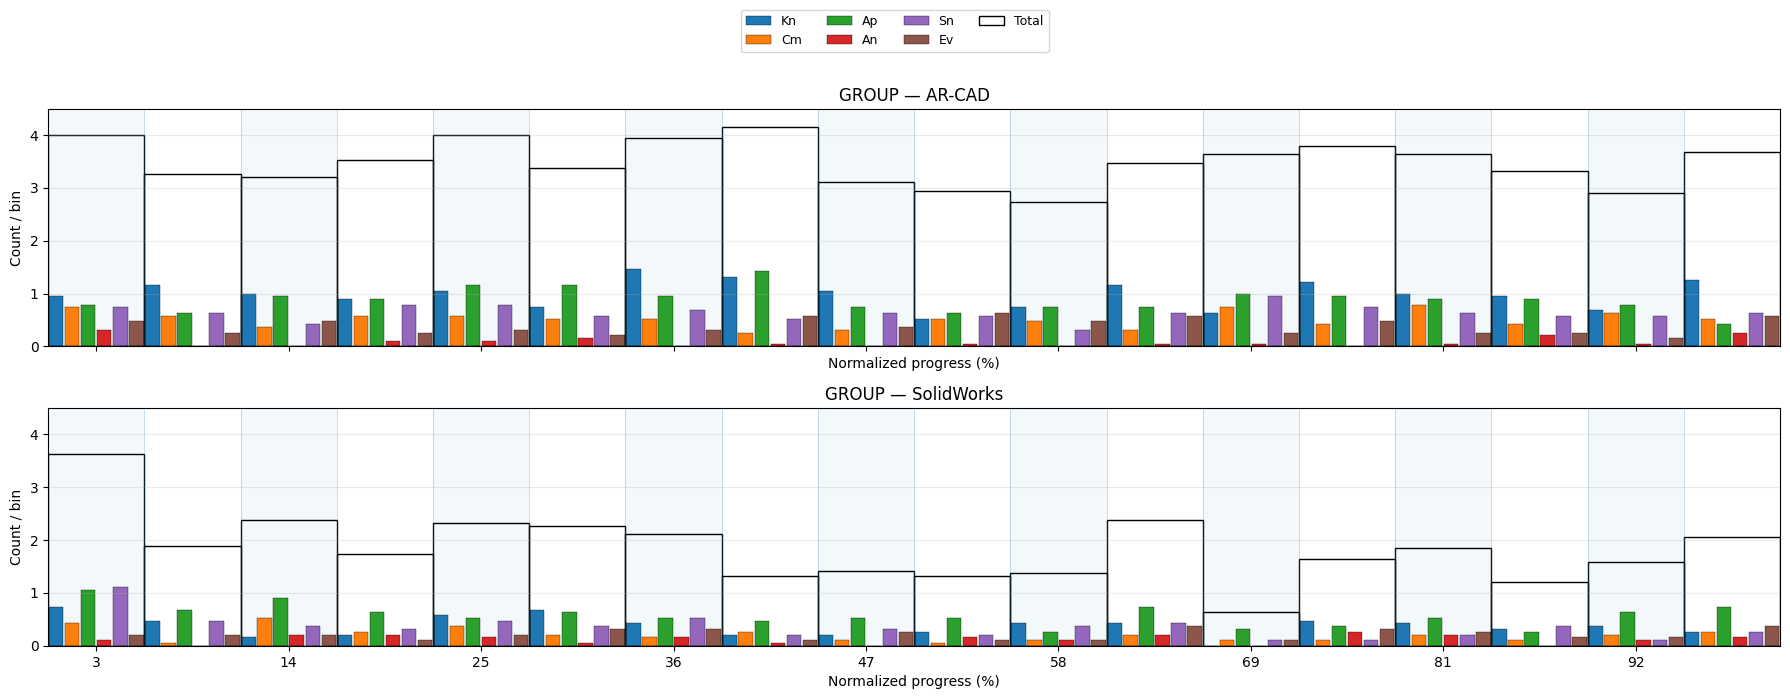

Saved plots to: D:\Thesis\Participants Data TRanscriptions\Participants Data\results\plots_bin20s_normalized_bocc_primary_MICROHIST_FIXED


In [ ]:
# ===== 10) Visualization (bin=20s): NORMALIZED progress micro-hist per bin (6 bars per bin)
#       — PERFECT BIN-COORD ALIGNMENT + % TICK LABELS + PID-only + SYNC Y =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# -------------------------
# USER SWITCHES
# -------------------------
BIN_S = 20
COUNT_MODE = "bocc_primary"     # bocc_primary / bocc_multi / buniq_primary / buniq_multi

TIME_MODE = "normalized"
NORM_BINS = 18                  # normalized progress bins (dimensionless)

EXPS = ["AR-CAD", "SolidWorks"]

MAKE_PARTICIPANT_PLOTS = True
MAKE_GROUP_MEAN_PLOTS = True

PARTICIPANTS = "ALL"            # "ALL" or list like ["P01","P02"]

# Plot readability
FIG_W_PER_BIN = 0.95
FIG_H = 6.8
SHOW_EVERY_NTH_XTICK = 2         # show every 2nd bin label (percent midpoint)

DRAW_BIN_BANDS = True
TOTAL_STYLE = "outline"          # "outline" (recommended) or "line"
SYNC_Y_BETWEEN_AR_SW = True
Y_PAD_FRAC = 0.08

SAVE_PNG = True
OUTDIR = Path(RESULTS_DIR) / f"plots_bin{BIN_S}s_{TIME_MODE}_{COUNT_MODE}_MICROHIST_FIXED"
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# Load per-bin data
# -------------------------
perbin = globals().get(f"perbin_{BIN_S}", None)
if not isinstance(perbin, pd.DataFrame) or perbin.empty:
    perbin_path = RESULTS_DIR / f"whisper_bloom_perbin_bin{BIN_S}s.csv"
    perbin = pd.read_csv(perbin_path)
    print("Loaded:", perbin_path)

perbin = perbin[perbin["bin_s"] == BIN_S].copy()

# normalize experiment naming
perbin["experiment"] = perbin["experiment"].astype(str).str.strip()
perbin["experiment"] = perbin["experiment"].replace({
    "unknown": "SolidWorks",
    "Unknown": "SolidWorks",
    "UNK": "SolidWorks",
    "sw": "SolidWorks",
    "SW": "SolidWorks",
    "solidworks": "SolidWorks",
})

# -------------------------
# PID-only (prefer participant_folder if present)
# -------------------------
def _pid_only(s: str) -> str:
    s = str(s).strip()
    m = re.search(r"\bP\s*0*(\d{1,3})\b", s, flags=re.IGNORECASE)
    if m:
        return f"P{int(m.group(1)):02d}"
    m = re.search(r"\bPID\s*0*(\d{1,3})\b", s, flags=re.IGNORECASE)
    if m:
        return f"P{int(m.group(1)):02d}"
    m = re.match(r"^\s*P\s*0*(\d{1,3})\b", s, flags=re.IGNORECASE)
    if m:
        return f"P{int(m.group(1)):02d}"
    return s

raw_col = "participant_folder" if "participant_folder" in perbin.columns else "participant"
perbin["participant_raw"] = perbin[raw_col].astype(str)
perbin["participant"] = perbin["participant_raw"].apply(_pid_only)

# mapping display (validation)
display(
    perbin[["participant_raw", "participant"]]
      .drop_duplicates()
      .sort_values("participant")
      .head(30)
)

# -------------------------
# Helpers
# -------------------------
def _cols_for_mode(mode: str):
    if mode == "bocc_primary":
        return [f"bocc_primary_{lab}" for lab in LABELS]
    if mode == "bocc_multi":
        return [f"bocc_{lab}" for lab in LABELS]
    if mode == "buniq_primary":
        return [f"buniq_primary_{lab}" for lab in LABELS]
    if mode == "buniq_multi":
        return [f"buniq_{lab}" for lab in LABELS]
    raise ValueError("COUNT_MODE must be one of: bocc_primary, bocc_multi, buniq_primary, buniq_multi")

VAL_COLS = _cols_for_mode(COUNT_MODE)
for c in VAL_COLS:
    if c not in perbin.columns:
        raise ValueError(f"Missing column {c} in perbin. Re-run your binning cells.")

def _duration_s(df_part: pd.DataFrame) -> float:
    if "end_s" in df_part.columns and df_part["end_s"].notna().any():
        m = float(df_part["end_s"].dropna().max())
        if m > 0:
            return m
    if "start_s" in df_part.columns and df_part["start_s"].notna().any():
        m = float(df_part["start_s"].dropna().max())
        return m + float(BIN_S)
    return float((int(df_part["bin_index"].max()) + 1) * BIN_S)

def _mid_s_row(r):
    if "t_mid_s" in r and pd.notna(r["t_mid_s"]):
        return float(r["t_mid_s"])
    if "start_s" in r and pd.notna(r["start_s"]):
        return float(r["start_s"]) + float(BIN_S) / 2.0
    return float(int(r["bin_index"]) * BIN_S) + float(BIN_S) / 2.0

def build_participant_table_normalized(df_part: pd.DataFrame) -> pd.DataFrame:
    """
    tau = t_mid/T in [0,1)
    pbin = floor(tau * NORM_BINS) in {0..NORM_BINS-1}
    Aggregate raw 20s bins -> normalized bins (sum), fill missing bins with zeros.
    """
    sub = df_part.sort_values("bin_index").copy()
    T = _duration_s(sub)

    sub["t_mid_s_use"] = sub.apply(_mid_s_row, axis=1)
    sub["t_norm"] = (sub["t_mid_s_use"] / T).clip(0, 0.999999)
    sub["pbin"] = np.floor(sub["t_norm"] * NORM_BINS).astype(int).clip(0, NORM_BINS - 1)

    agg = sub.groupby(["participant", "experiment", "pbin"], as_index=False)[VAL_COLS].sum()

    pbins = np.arange(NORM_BINS, dtype=int)
    full = pd.MultiIndex.from_product(
        [[sub["participant"].iloc[0]], [sub["experiment"].iloc[0]], pbins],
        names=["participant", "experiment", "pbin"]
    )
    agg = agg.set_index(["participant", "experiment", "pbin"]).reindex(full).fillna(0).reset_index()
    agg["pbin"] = agg["pbin"].astype(int)
    return agg

def _ensure_full(sub, pid, exp):
    pb = np.arange(NORM_BINS, dtype=int)
    if sub is None or len(sub) == 0:
        z = pd.DataFrame({"participant":[pid]*NORM_BINS, "experiment":[exp]*NORM_BINS, "pbin":pb})
        for c in VAL_COLS:
            z[c] = 0.0
        return z
    tmp = sub.set_index("pbin")[VAL_COLS].reindex(pb).fillna(0.0).reset_index()
    tmp["participant"] = pid
    tmp["experiment"] = exp
    return tmp[["participant","experiment","pbin"] + VAL_COLS]

def _dedupe_legend(handles, labels):
    seen = {}
    for h, l in zip(handles, labels):
        if l not in seen:
            seen[l] = h
    return list(seen.values()), list(seen.keys())

def _ymax_for(sub):
    y_dom = float(sub[VAL_COLS].to_numpy().max())
    y_tot = float(sub[VAL_COLS].sum(axis=1).to_numpy().max())
    return max(y_dom, y_tot)

# -------------------------
# PERFECTLY-ALIGNED MICROHIST
#   X-axis is bin-units: each bin is exactly [k, k+1]
#   Tick labels are % midpoints to keep interpretation simple
# -------------------------
def microhist_bincoords(ax, sub, title):
    """
    PERFECT alignment using LEFT-EDGE bars (align='edge').

    Bin k spans exactly [k, k+1].
    Each domain occupies a fixed slot inside the bin using left edges.
    Total is an outline rectangle spanning the whole bin, also left-edge aligned.
    """
    n_dom = len(LABELS)
    pbins = np.arange(NORM_BINS, dtype=int)

    sub = sub.sort_values("pbin").copy()
    sub = sub.set_index("pbin")[VAL_COLS].reindex(pbins).fillna(0.0).reset_index()
    sub["pbin"] = sub["pbin"].astype(int)

    # Bin left edge coordinates: exactly integers
    x_left = sub["pbin"].to_numpy(dtype=float)  # 0,1,2,...,NORM_BINS-1

    # Values
    Y = np.vstack([sub[c].to_numpy(dtype=float) for c in VAL_COLS])
    totals = Y.sum(axis=0)

    # Background zebra + boundary lines at exact integers
    if DRAW_BIN_BANDS:
        for k in range(NORM_BINS):
            if k % 2 == 0:
                ax.axvspan(k, k + 1, alpha=0.05)

    for k in range(NORM_BINS + 1):
        ax.axvline(k, linewidth=0.7, alpha=0.25)

    # Domain bars: compute LEFT EDGES inside each bin
    slot_w = 1.0 / n_dom
    pad = slot_w * 0.10
    bar_w = slot_w - pad

    for j, lab in enumerate(LABELS):
        # left edge inside bin: k + j*slot_w + pad/2
        x_bar_left = x_left + j * slot_w + pad / 2.0
        ax.bar(
            x_bar_left,
            Y[j, :],
            width=bar_w,
            align="edge",              # <-- key alignment fix
            edgecolor="black",
            linewidth=0.25,
            label=lab
        )

    # Total: outline rectangle spanning exactly [k, k+1]
    if TOTAL_STYLE == "outline":
        ax.bar(
            x_left,
            totals,
            width=1.0,
            align="edge",              # <-- same alignment rule
            fill=False,
            edgecolor="black",
            linewidth=1.0,
            label="Total"
        )
    elif TOTAL_STYLE == "line":
        ax.plot(x_left + 0.5, totals, marker="o", linewidth=1.1, label="Total")
    else:
        raise ValueError("TOTAL_STYLE must be 'outline' or 'line'")

    # X ticks at bin midpoints (k+0.5), labeled as % midpoint
    ax.set_xlim(0, NORM_BINS)
    tick_bins = np.arange(0, NORM_BINS, SHOW_EVERY_NTH_XTICK, dtype=int)
    tick_pos = tick_bins + 0.5
    tick_lab = [str(int(round((k + 0.5) * 100.0 / NORM_BINS))) for k in tick_bins]

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lab)

    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)
    ax.set_ylabel("Count / bin")
    ax.set_xlabel("Normalized progress (%)")

# keep compatibility name
plot_micro_hist_percent = microhist_bincoords

# -------------------------
# Build plot table
# -------------------------
if TIME_MODE != "normalized":
    raise ValueError("This cell is designed for TIME_MODE='normalized' only.")

tables = []
for (p, exp), sub in perbin.groupby(["participant","experiment"]):
    if exp not in EXPS:
        continue
    tables.append(build_participant_table_normalized(sub))

df_plot_all = pd.concat(tables, ignore_index=True) if tables else pd.DataFrame()
display(df_plot_all.head(10))

plot_table_path = RESULTS_DIR / f"plot_table_bin{BIN_S}s_{TIME_MODE}_{COUNT_MODE}_MICROHIST_FIXED.csv"
df_plot_all.to_csv(plot_table_path, index=False)
print("Saved plot table:", plot_table_path)

# -------------------------
# Participant plots: ONE combined figure per participant (AR-CAD + SolidWorks)
# -------------------------
if MAKE_PARTICIPANT_PLOTS and not df_plot_all.empty:
    plist = sorted(df_plot_all["participant"].unique()) if PARTICIPANTS == "ALL" else list(PARTICIPANTS)

    for pid in plist:
        subA = df_plot_all[(df_plot_all["participant"]==pid) & (df_plot_all["experiment"]=="AR-CAD")].copy()
        subS = df_plot_all[(df_plot_all["participant"]==pid) & (df_plot_all["experiment"]=="SolidWorks")].copy()

        subA = _ensure_full(subA, pid, "AR-CAD")
        subS = _ensure_full(subS, pid, "SolidWorks")

        fig_w = max(18.0, NORM_BINS * FIG_W_PER_BIN)
        fig, axes = plt.subplots(2, 1, figsize=(fig_w, FIG_H), sharex=True)
        axes = np.array(axes).ravel()

        plot_micro_hist_percent(axes[0], subA, f"{pid} — AR-CAD")
        plot_micro_hist_percent(axes[1], subS, f"{pid} — SolidWorks")

        # Sync y-scale between AR & SW so "levels" are comparable
        if SYNC_Y_BETWEEN_AR_SW:
            ymax = max(_ymax_for(subA), _ymax_for(subS))
            ymax = max(1.0, ymax) * (1.0 + Y_PAD_FRAC)
            axes[0].set_ylim(0, ymax)
            axes[1].set_ylim(0, ymax)

        # One clean legend outside
        h, l = axes[0].get_legend_handles_labels()
        h2, l2 = _dedupe_legend(h, l)
        fig.legend(h2, l2, ncol=4, fontsize=9, loc="upper center", bbox_to_anchor=(0.5, 1.03))

        fig.tight_layout(rect=[0, 0, 1, 0.93])

        if SAVE_PNG:
            fig.savefig(OUTDIR / f"{pid}_COMBINED_MICROHIST_FIXED.png", dpi=200, bbox_inches="tight")
        plt.show()

# -------------------------
# Group mean plots (AR-CAD + SolidWorks combined)
# -------------------------
if MAKE_GROUP_MEAN_PLOTS and not df_plot_all.empty:
    g = df_plot_all.groupby(["experiment","pbin"], as_index=False)[VAL_COLS].mean()

    pb = np.arange(NORM_BINS, dtype=int)
    def _ensure_full_group(sub, exp):
        tmp = sub.set_index("pbin")[VAL_COLS].reindex(pb).fillna(0.0).reset_index()
        tmp["experiment"] = exp
        return tmp[["experiment","pbin"] + VAL_COLS]

    subA = _ensure_full_group(g[g["experiment"]=="AR-CAD"], "AR-CAD")
    subS = _ensure_full_group(g[g["experiment"]=="SolidWorks"], "SolidWorks")

    fig_w = max(18.0, NORM_BINS * FIG_W_PER_BIN)
    fig, axes = plt.subplots(2, 1, figsize=(fig_w, FIG_H), sharex=True)
    axes = np.array(axes).ravel()

    plot_micro_hist_percent(axes[0], subA, "GROUP — AR-CAD")
    plot_micro_hist_percent(axes[1], subS, "GROUP — SolidWorks")

    if SYNC_Y_BETWEEN_AR_SW:
        ymax = max(_ymax_for(subA.rename(columns={"pbin":"pbin"})), _ymax_for(subS.rename(columns={"pbin":"pbin"})))
        ymax = max(1.0, ymax) * (1.0 + Y_PAD_FRAC)
        axes[0].set_ylim(0, ymax)
        axes[1].set_ylim(0, ymax)

    h, l = axes[0].get_legend_handles_labels()
    h2, l2 = _dedupe_legend(h, l)
    fig.legend(h2, l2, ncol=4, fontsize=9, loc="upper center", bbox_to_anchor=(0.5, 1.03))
    fig.tight_layout(rect=[0, 0, 1, 0.93])

    if SAVE_PNG:
        fig.savefig(OUTDIR / "GROUP_COMBINED_MICROHIST_FIXED.png", dpi=200, bbox_inches="tight")
    plt.show()

print("Saved plots to:", OUTDIR)


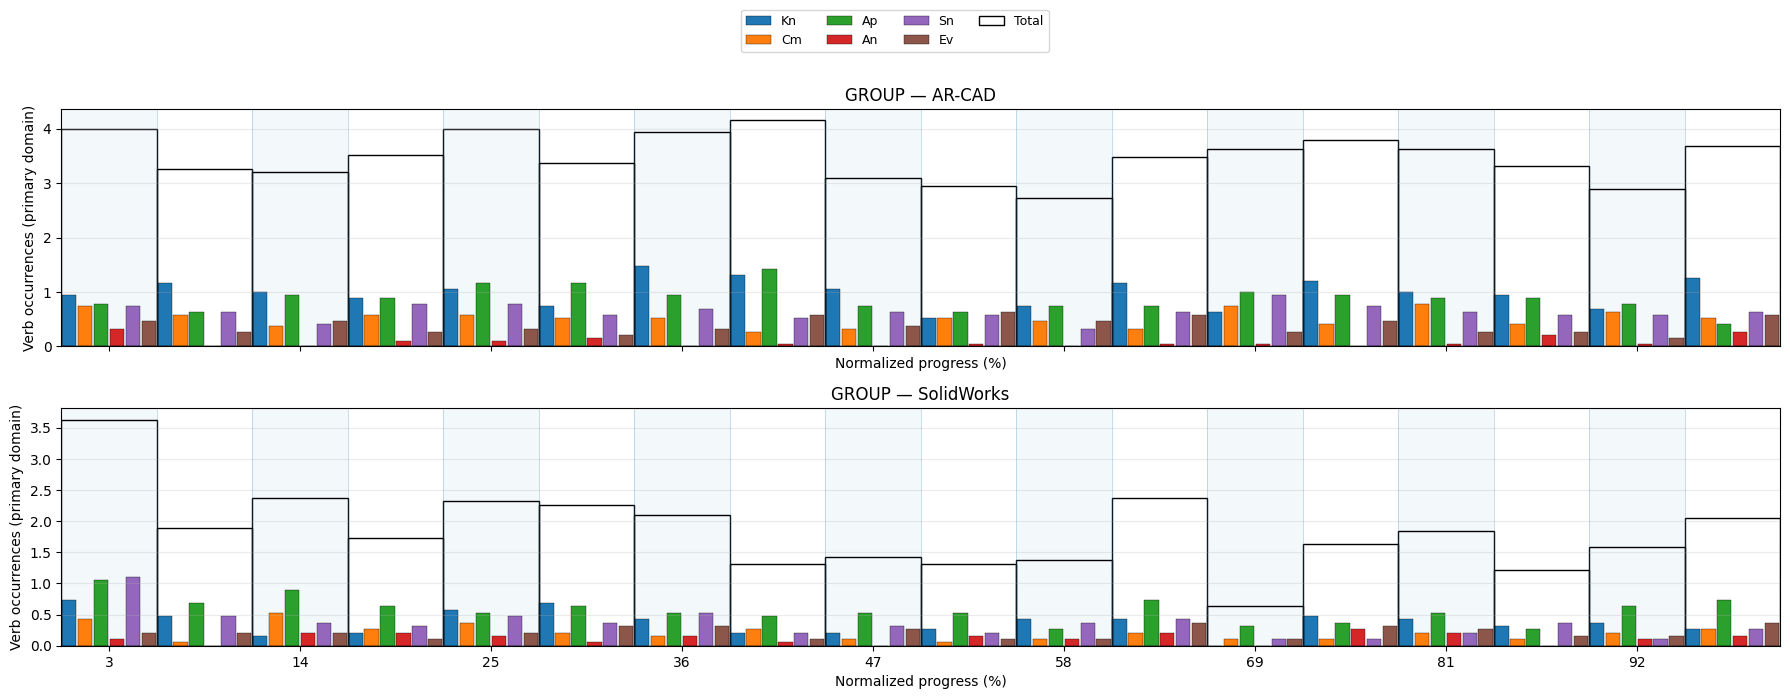

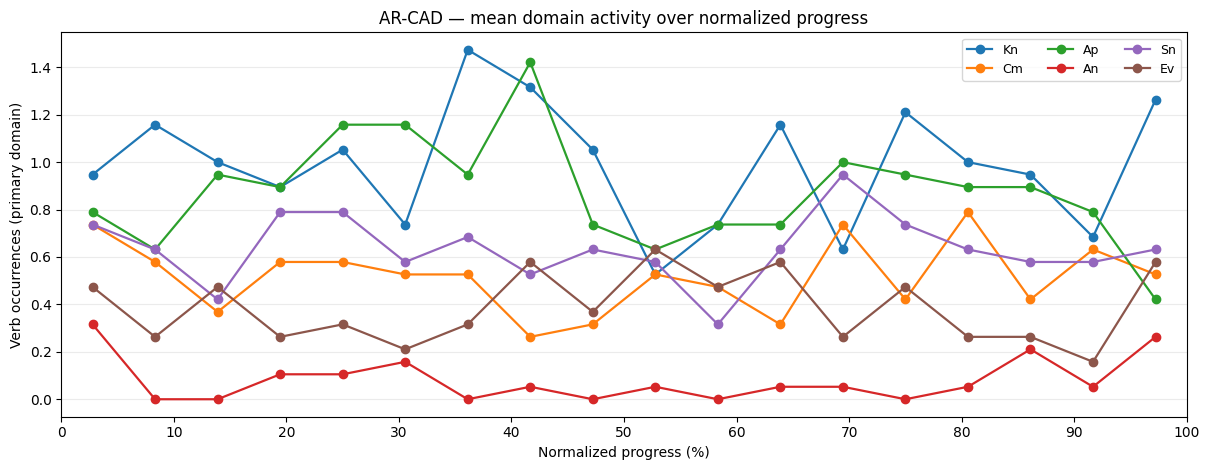

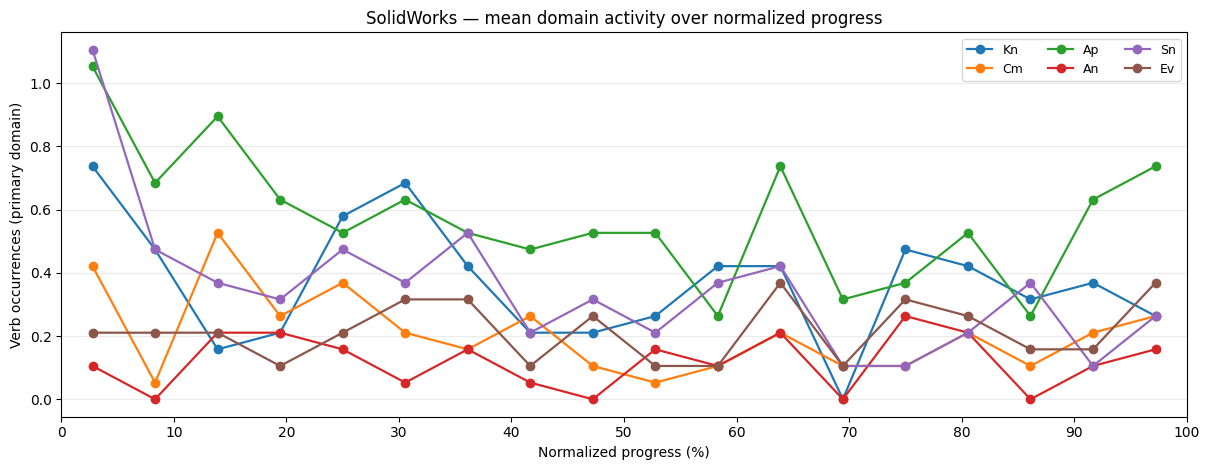

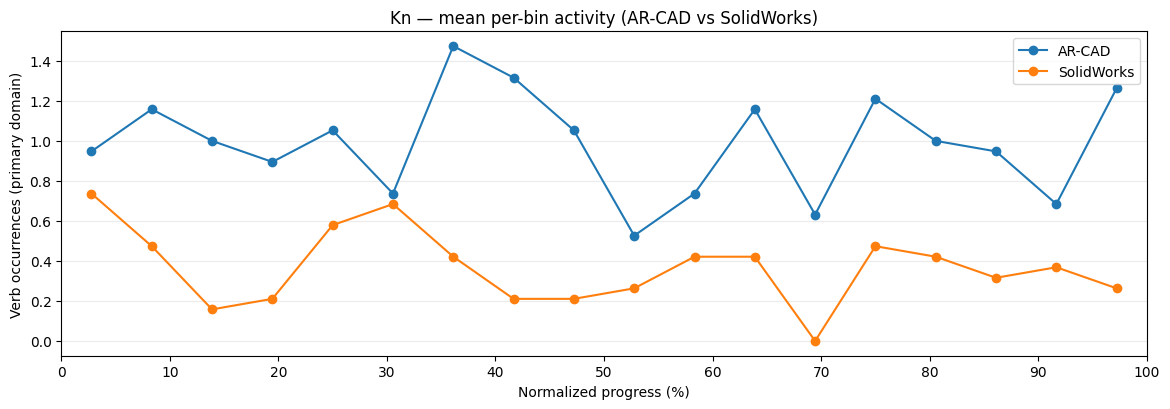

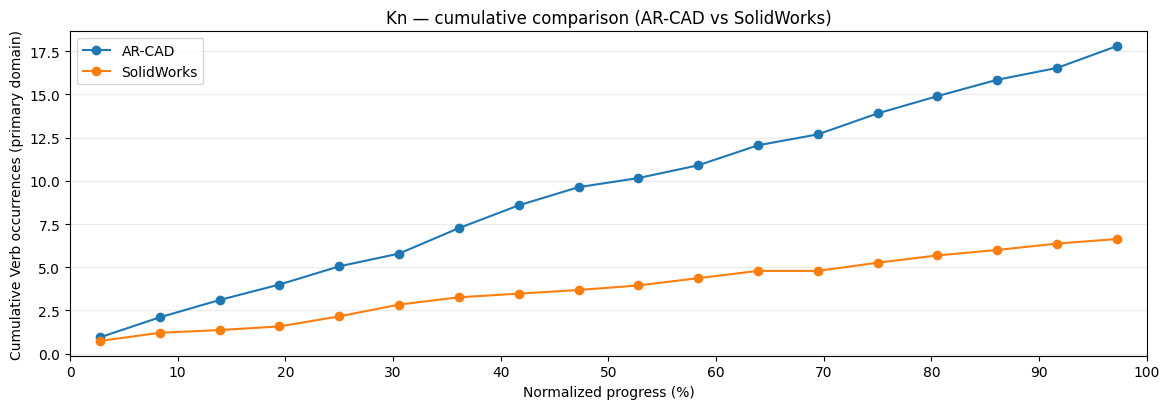

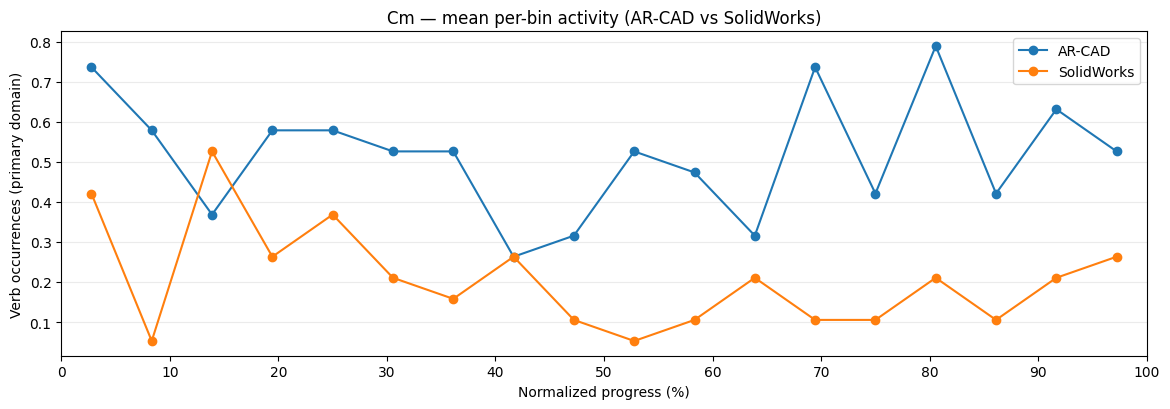

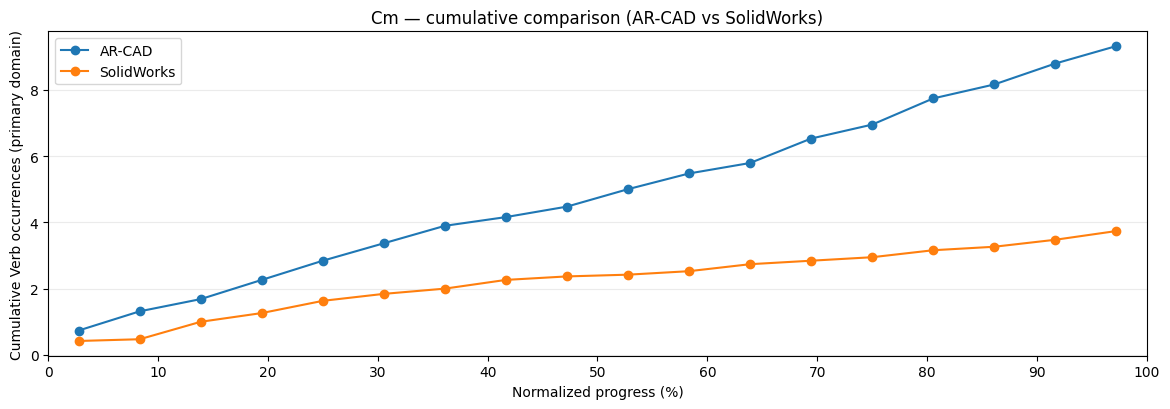

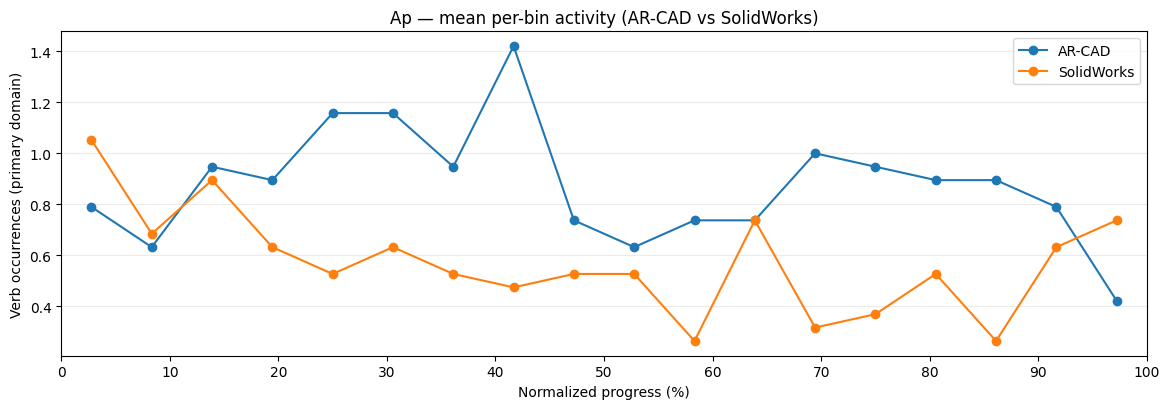

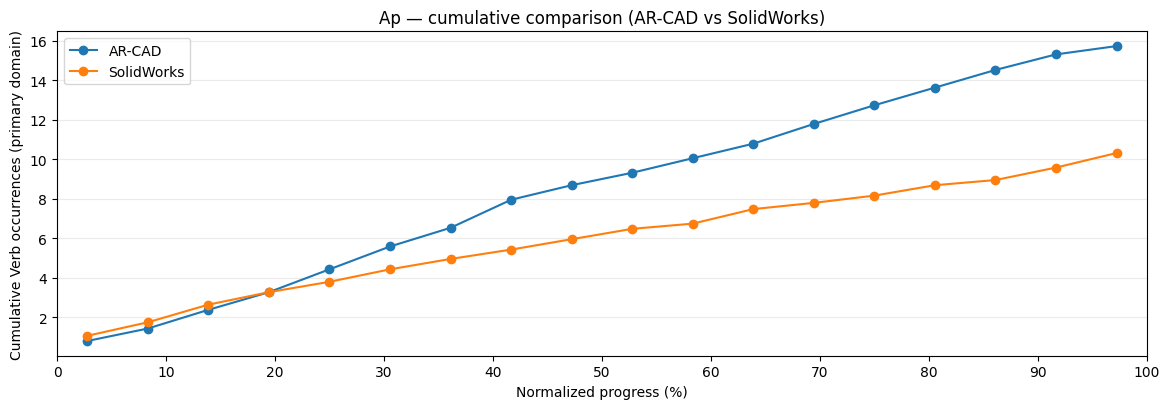

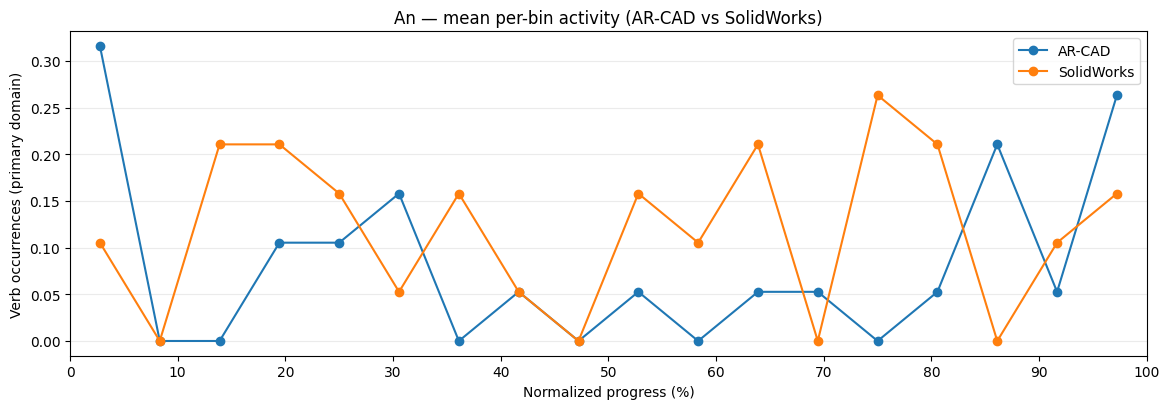

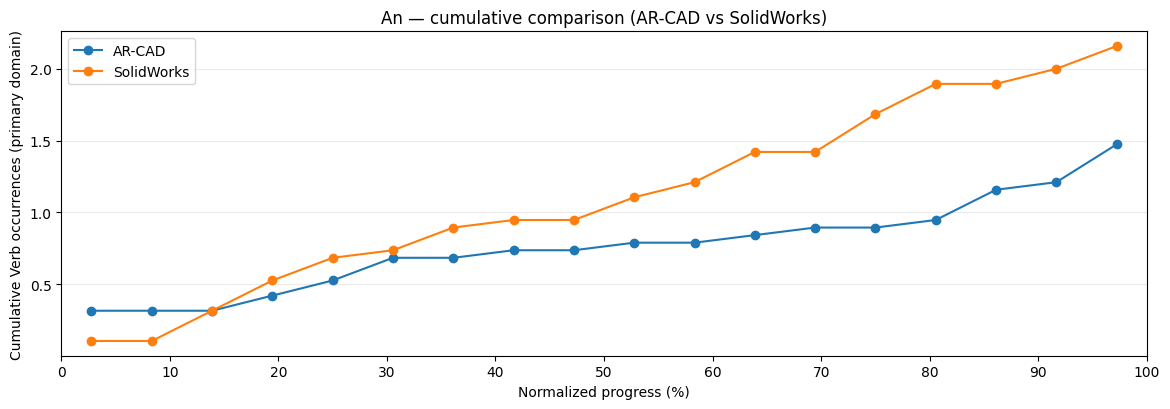

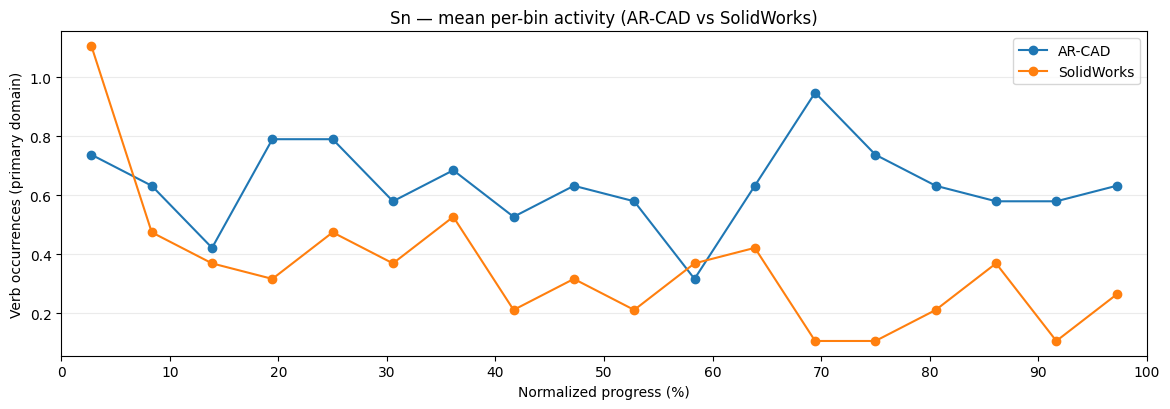

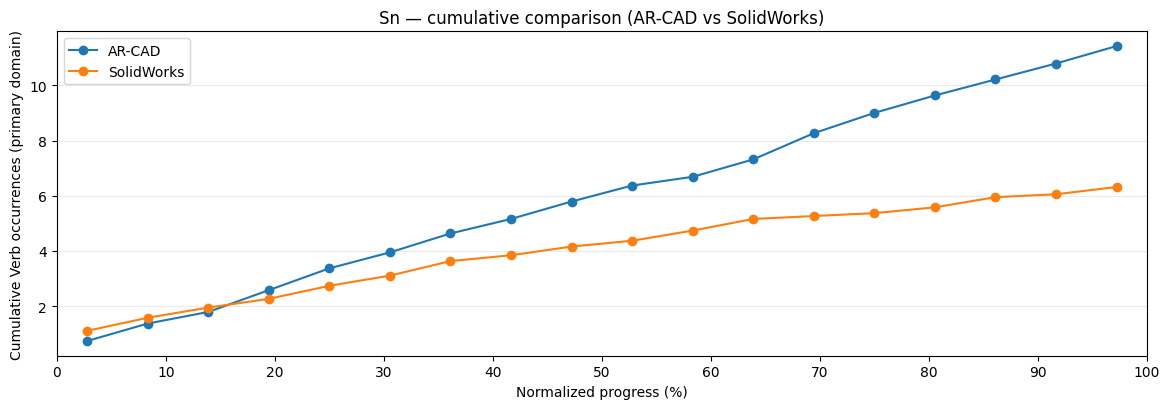

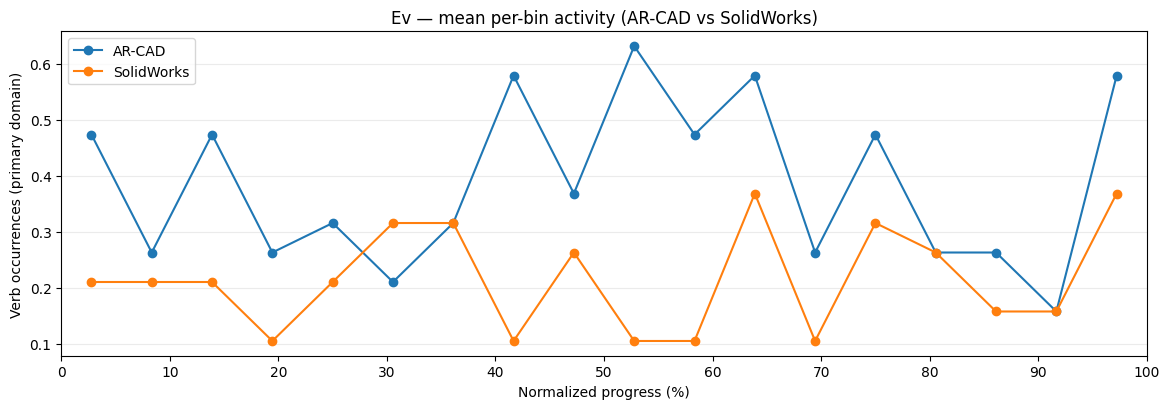

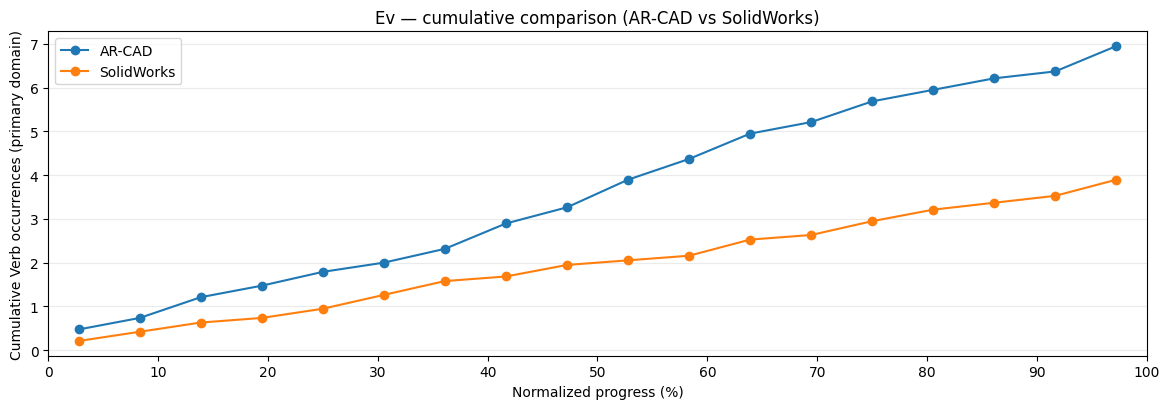

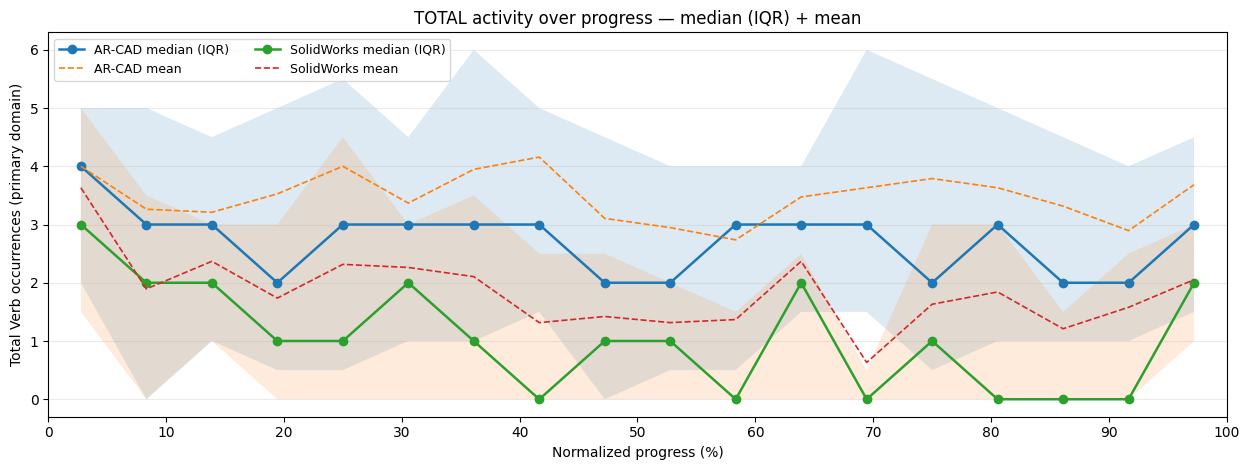

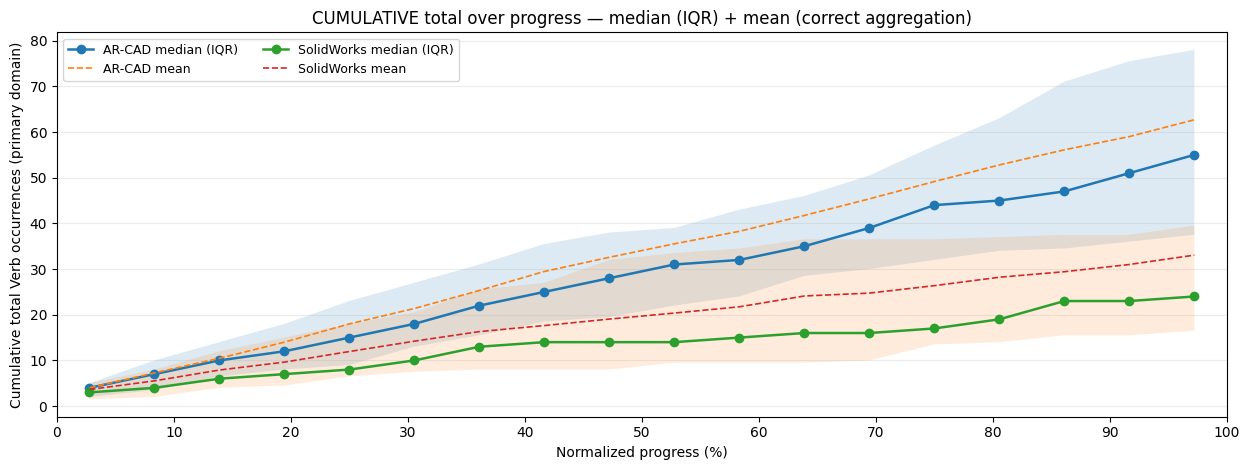

✅ Group plots saved in: D:\Thesis\Participants Data TRanscriptions\Participants Data\results\plots_bin20s_normalized_bocc_primary_MICROHIST_FIXED


In [ ]:
# ===== 11) GROUPED normalized-progress analysis (AR-CAD vs SolidWorks)
#       + group micro-histograms + domain lines + comparisons + total stats =====
# Requires df_plot_all from Cell 10 (participant-level normalized pbins with VAL_COLS).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "df_plot_all" in globals(), "Run Cell 10 first so df_plot_all exists."
assert TIME_MODE == "normalized", "This cell expects normalized progress."
assert "VAL_COLS" in globals() and "LABELS" in globals(), "Cell 10 must define VAL_COLS and LABELS."
assert "NORM_BINS" in globals(), "Cell 10 must define NORM_BINS."
assert "COUNT_MODE" in globals(), "Cell 10 must define COUNT_MODE."

SAVE_PNG_11 = True
EXPS2 = ["AR-CAD", "SolidWorks"]

# ----- Descriptive metric label (instead of bocc_primary etc.) -----
METRIC_LABEL_MAP = {
    "bocc_primary":  "Verb occurrences (primary domain)",
    "bocc_multi":    "Verb occurrences (multi-label)",
    "buniq_primary": "Unique verbs (primary domain)",
    "buniq_multi":   "Unique verbs (multi-label)",
}
METRIC_LABEL = METRIC_LABEL_MAP.get(COUNT_MODE, "Verb/domain counts")

pbins = np.arange(NORM_BINS, dtype=int)
BIN_PCT = 100.0 / NORM_BINS
x_pct_mid = (pbins + 0.5) * BIN_PCT

# Use existing OUTDIR if present
if "OUTDIR" not in globals():
    from pathlib import Path
    OUTDIR = Path(RESULTS_DIR) / f"plots_normalized_GROUP"
    OUTDIR.mkdir(parents=True, exist_ok=True)

FIG_W = max(18.0, NORM_BINS * 0.95)
FIG_H = 6.8

# ------------------------------------------------------------
# Prepare dfG with pbin + full bin coverage per participant/experiment
# ------------------------------------------------------------
dfG = df_plot_all.copy()

if "pbin" not in dfG.columns:
    if "x" in dfG.columns:
        dfG["pbin"] = dfG["x"].astype(int)
    else:
        raise ValueError("df_plot_all must contain pbin or x.")

dfG["experiment"] = dfG["experiment"].astype(str).str.strip().replace({
    "unknown": "SolidWorks",
    "Unknown": "SolidWorks",
    "UNK": "SolidWorks",
    "sw": "SolidWorks",
    "SW": "SolidWorks",
})
dfG = dfG[dfG["experiment"].isin(EXPS2)].copy()

def ensure_full_bins(df_in: pd.DataFrame) -> pd.DataFrame:
    out = []
    for (p, exp), sub in df_in.groupby(["participant","experiment"]):
        tmp = sub.set_index("pbin")[VAL_COLS].reindex(pbins).fillna(0.0).reset_index()
        tmp["participant"] = p
        tmp["experiment"] = exp
        out.append(tmp[["participant","experiment","pbin"] + VAL_COLS])
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

dfG = ensure_full_bins(dfG)

# group mean per experiment per pbin
g_mean = (
    dfG.groupby(["experiment","pbin"], as_index=False)[VAL_COLS]
       .mean()
       .sort_values(["experiment","pbin"])
       .reset_index(drop=True)
)

# ------------------------------------------------------------
# Helpers: robust quantiles (avoids KeyError issues)
# ------------------------------------------------------------
def add_quantiles(stats_base: pd.DataFrame, series_df: pd.DataFrame, value_col: str) -> pd.DataFrame:
    q = (series_df.groupby(["experiment","pbin"])[value_col]
                  .quantile([0.25, 0.75])
                  .unstack(level=-1)
                  .reset_index()
                  .rename(columns={0.25:"q25", 0.75:"q75"}))
    return stats_base.merge(q, on=["experiment","pbin"], how="left")

def dedupe_legend(handles, labels):
    seen = {}
    for h, l in zip(handles, labels):
        if l not in seen:
            seen[l] = h
    return list(seen.values()), list(seen.keys())

# ============================================================
# (A) GROUP MICRO-HISTOGRAMS (PERFECT BIN-COORD ALIGNMENT)
#     (Same bin-coordinate logic as Cell 10: align='edge')
# ============================================================
def microhist_group_bincoords(ax, sub_mean, title, draw_bands=True):
    sub = sub_mean.set_index("pbin")[VAL_COLS].reindex(pbins).fillna(0.0).reset_index()
    x_left = sub["pbin"].to_numpy(dtype=float)

    Y = np.vstack([sub[c].to_numpy(dtype=float) for c in VAL_COLS])
    totals = Y.sum(axis=0)

    n_dom = len(LABELS)
    slot_w = 1.0 / n_dom
    pad = slot_w * 0.10
    bar_w = slot_w - pad

    if draw_bands:
        for k in range(NORM_BINS):
            if k % 2 == 0:
                ax.axvspan(k, k+1, alpha=0.05)
    for k in range(NORM_BINS + 1):
        ax.axvline(k, linewidth=0.7, alpha=0.25)

    for j, lab in enumerate(LABELS):
        x_bar_left = x_left + j*slot_w + pad/2.0
        ax.bar(x_bar_left, Y[j, :], width=bar_w, align="edge",
               edgecolor="black", linewidth=0.25, label=lab)

    ax.bar(x_left, totals, width=1.0, align="edge", fill=False,
           edgecolor="black", linewidth=1.0, label="Total")

    tick_bins = np.arange(0, NORM_BINS, max(1, int(np.ceil(NORM_BINS/10))), dtype=int)
    tick_pos  = tick_bins + 0.5
    tick_lab  = [str(int(round((k + 0.5) * 100.0 / NORM_BINS))) for k in tick_bins]
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_lab)

    ax.set_xlim(0, NORM_BINS)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)
    ax.set_ylabel(METRIC_LABEL)
    ax.set_xlabel("Normalized progress (%)")

def plot_group_microhist():
    subA = g_mean[g_mean["experiment"]=="AR-CAD"][["pbin"] + VAL_COLS].copy()
    subS = g_mean[g_mean["experiment"]=="SolidWorks"][["pbin"] + VAL_COLS].copy()

    fig, axes = plt.subplots(2, 1, figsize=(FIG_W, FIG_H), sharex=True)
    axes = np.array(axes).ravel()

    microhist_group_bincoords(axes[0], subA, "GROUP — AR-CAD")
    microhist_group_bincoords(axes[1], subS, "GROUP — SolidWorks")

    h, l = axes[0].get_legend_handles_labels()
    h, l = dedupe_legend(h, l)
    fig.legend(h, l, ncol=4, fontsize=9, loc="upper center", bbox_to_anchor=(0.5, 1.03))
    fig.tight_layout(rect=[0, 0, 1, 0.93])

    if SAVE_PNG_11:
        fig.savefig(OUTDIR / f"GROUP_microhist.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_group_microhist()

# ============================================================
# (B) ONE GRAPH PER EXPERIMENT: all 6 domains over progress (mean per bin)
# ============================================================
def plot_all_domains_one_exp(exp: str):
    sub = g_mean[g_mean["experiment"]==exp].set_index("pbin")[VAL_COLS].reindex(pbins).fillna(0.0).reset_index()

    plt.figure(figsize=(12.2, 4.8))
    for j, lab in enumerate(LABELS):
        plt.plot(x_pct_mid, sub[VAL_COLS[j]].to_numpy(), marker="o", linewidth=1.6, label=lab)

    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel("Normalized progress (%)")
    plt.ylabel(METRIC_LABEL)
    plt.title(f"{exp} — mean domain activity over normalized progress")
    plt.grid(axis="y", alpha=0.25)
    plt.legend(ncol=3, fontsize=9)
    plt.tight_layout()

    if SAVE_PNG_11:
        plt.savefig(OUTDIR / f"{exp}_all_domains_over_progress.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_all_domains_one_exp("AR-CAD")
plot_all_domains_one_exp("SolidWorks")

# ============================================================
# (C) PER-DOMAIN COMPARISON: counts-per-bin + cumulative AR vs SW
# ============================================================
def plot_domain_comparison(domain_lab: str, col_name: str):
    a = g_mean[g_mean["experiment"]=="AR-CAD"].set_index("pbin")[col_name].reindex(pbins).fillna(0.0).to_numpy()
    s = g_mean[g_mean["experiment"]=="SolidWorks"].set_index("pbin")[col_name].reindex(pbins).fillna(0.0).to_numpy()

    # per-bin mean activity
    plt.figure(figsize=(11.8, 4.2))
    plt.plot(x_pct_mid, a, marker="o", label="AR-CAD")
    plt.plot(x_pct_mid, s, marker="o", label="SolidWorks")
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel("Normalized progress (%)")
    plt.ylabel(METRIC_LABEL)
    plt.title(f"{domain_lab} — mean per-bin activity (AR-CAD vs SolidWorks)")
    plt.grid(axis="y", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    if SAVE_PNG_11:
        plt.savefig(OUTDIR / f"{domain_lab}_per_bin_AR_vs_SW.png", dpi=200, bbox_inches="tight")
    plt.show()

    # cumulative
    a_cum = np.cumsum(a)
    s_cum = np.cumsum(s)
    plt.figure(figsize=(11.8, 4.2))
    plt.plot(x_pct_mid, a_cum, marker="o", label="AR-CAD")
    plt.plot(x_pct_mid, s_cum, marker="o", label="SolidWorks")
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel("Normalized progress (%)")
    plt.ylabel(f"Cumulative {METRIC_LABEL}")
    plt.title(f"{domain_lab} — cumulative comparison (AR-CAD vs SolidWorks)")
    plt.grid(axis="y", alpha=0.25)
    plt.legend()
    plt.tight_layout()
    if SAVE_PNG_11:
        plt.savefig(OUTDIR / f"{domain_lab}_cumulative_AR_vs_SW.png", dpi=200, bbox_inches="tight")
    plt.show()

for lab, col in zip(LABELS, VAL_COLS):
    plot_domain_comparison(lab, col)

# ============================================================
# (D) TOTAL ACTIVITY: median + IQR band + mean across participants
# ============================================================
def plot_group_total_activity(df_in: pd.DataFrame):
    tmp = df_in.copy()
    tmp["total"] = tmp[VAL_COLS].sum(axis=1)

    base = (tmp.groupby(["experiment","pbin"])["total"]
              .agg(mean="mean", median="median")
              .reset_index())
    stats = add_quantiles(base, tmp[["experiment","pbin","total"]], "total")

    plt.figure(figsize=(12.6, 4.8))
    for exp in EXPS2:
        sub = stats[stats["experiment"]==exp].sort_values("pbin")
        x = (sub["pbin"].to_numpy() + 0.5) * BIN_PCT
        plt.fill_between(x, sub["q25"].to_numpy(), sub["q75"].to_numpy(), alpha=0.15)
        plt.plot(x, sub["median"].to_numpy(), marker="o", linewidth=1.8, label=f"{exp} median (IQR)")
        plt.plot(x, sub["mean"].to_numpy(), linestyle="--", linewidth=1.2, label=f"{exp} mean")

    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel("Normalized progress (%)")
    plt.ylabel(f"Total {METRIC_LABEL}")
    plt.title("TOTAL activity over progress — median (IQR) + mean")
    plt.grid(axis="y", alpha=0.25)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()

    if SAVE_PNG_11:
        plt.savefig(OUTDIR / f"TOTAL_activity_over_progress.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_group_total_activity(dfG)

# ============================================================
# (E) CUMULATIVE TOTAL: correct aggregation (per participant cumulative -> stats)
# ============================================================
def plot_group_cumulative_total(df_in: pd.DataFrame):
    tmp = df_in.copy().sort_values(["participant","experiment","pbin"])
    tmp["total"] = tmp[VAL_COLS].sum(axis=1)
    tmp["cum_total"] = tmp.groupby(["participant","experiment"])["total"].cumsum()

    base = (tmp.groupby(["experiment","pbin"])["cum_total"]
              .agg(mean="mean", median="median")
              .reset_index())
    stats = add_quantiles(base, tmp[["experiment","pbin","cum_total"]], "cum_total")

    plt.figure(figsize=(12.6, 4.8))
    for exp in EXPS2:
        sub = stats[stats["experiment"]==exp].sort_values("pbin")
        x = (sub["pbin"].to_numpy() + 0.5) * BIN_PCT
        plt.fill_between(x, sub["q25"].to_numpy(), sub["q75"].to_numpy(), alpha=0.15)
        plt.plot(x, sub["median"].to_numpy(), marker="o", linewidth=1.8, label=f"{exp} median (IQR)")
        plt.plot(x, sub["mean"].to_numpy(), linestyle="--", linewidth=1.2, label=f"{exp} mean")

    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 10))
    plt.xlabel("Normalized progress (%)")
    plt.ylabel(f"Cumulative total {METRIC_LABEL}")
    plt.title("CUMULATIVE total over progress — median (IQR) + mean (correct aggregation)")
    plt.grid(axis="y", alpha=0.25)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()

    if SAVE_PNG_11:
        plt.savefig(OUTDIR / f"CUMULATIVE_total_over_progress.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_group_cumulative_total(dfG)

print("✅ Group plots saved in:", OUTDIR)


In [ ]:
# ===== 11) Export an organized verb-level CSV (for manual analysis) =====
# LONG table (one row per (participant_id, experiment, bin, verb)):
#   - repetition-aware count_in_bin
#   - primary_label and multi_labels
#   - bin transcript text for manual review
# NOTE: participant IDs are anonymized using Participants ID.csv

import json
import pandas as pd
import re
from pathlib import Path

BIN_S = 20

# Load perbin if needed
perbin = globals().get(f"perbin_{BIN_S}", None)
if not isinstance(perbin, pd.DataFrame) or perbin.empty:
    perbin_path = RESULTS_DIR / f"whisper_bloom_perbin_bin{BIN_S}s.csv"
    perbin = pd.read_csv(perbin_path)
    print("Loaded:", perbin_path)

perbin = perbin[perbin["bin_s"] == BIN_S].copy()

# ---- Anonymize participants ----
PID_CSV = Path("/mnt/data/Participants ID.csv")
if PID_CSV.exists():
    df_ids = pd.read_csv(PID_CSV)
    name_col = None
    id_col = None
    for c in df_ids.columns:
        cl = str(c).strip().lower()
        if "please write your name" in cl or cl in ("name","participant name","participant"):
            name_col = c
        if "participant id" in cl or cl in ("id","participant_id"):
            id_col = c
    if name_col is None or id_col is None:
        name_col = "Please write your name:" if "Please write your name:" in df_ids.columns else df_ids.columns[1]
        id_col = "Participant ID" if "Participant ID" in df_ids.columns else df_ids.columns[2]

    def _norm_name(s: str) -> str:
        s = str(s).strip().lower()
        s = re.sub(r"\s+", " ", s)
        return s

    id_map = {}
    for _, r in df_ids.iterrows():
        nm = r.get(name_col, None)
        pid = r.get(id_col, None)
        if pd.isna(nm) or pd.isna(pid):
            continue
        id_map[_norm_name(nm)] = str(pid).strip()

    perbin["participant_raw"] = perbin["participant"].astype(str)
    missing = sorted({ _norm_name(x) for x in perbin["participant_raw"].unique() if _norm_name(x) not in id_map })
    fallback = {nm: f"UNK{j+1:02d}" for j, nm in enumerate(missing)}
    perbin["participant_id"] = perbin["participant_raw"].apply(lambda x: id_map.get(_norm_name(x), fallback.get(_norm_name(x), x)))
else:
    perbin["participant_id"] = perbin["participant"].astype(str)

def _safe_json(s, default):
    try:
        if isinstance(s, str) and s.strip() != "":
            return json.loads(s)
        return default
    except Exception:
        return default

rows = []
for _, r in perbin.iterrows():
    participant_id = r.get("participant_id","")
    exp = r.get("experiment","")
    bin_index = int(r.get("bin_index",-1))
    start_s = r.get("start_s", None)
    end_s = r.get("end_s", None)
    t_mid_s = r.get("t_mid_s", None)
    n_words = int(r.get("n_words", 0))
    text = r.get("text","")

    ok_counts = _safe_json(r.get("ok_counts_map","{}"), {})
    if not isinstance(ok_counts, dict):
        ok_counts = {}

    primary_map = _safe_json(r.get("buniq_primary_map","{}"), {})
    labels_map = _safe_json(r.get("buniq_labels_map","{}"), {})

    # One row per verb in this bin (with repetition count)
    for v, c in ok_counts.items():
        v = str(v)
        c = int(c)
        rows.append({
            "participant_id": participant_id,
            "experiment": exp,
            "bin_s": BIN_S,
            "bin_index": bin_index,
            "start_s": start_s,
            "end_s": end_s,
            "t_mid_s": t_mid_s,
            "n_words": n_words,
            "verb": v,
            "count_in_bin": c,  # repetition-aware
            "primary_label": primary_map.get(v, None),
            "multi_labels": ",".join(labels_map.get(v, [])) if isinstance(labels_map.get(v, []), list) else "",
            "text": text,
        })

df_verbs_long = pd.DataFrame(rows)

# Sort nicely (chronological within participant/experiment)
df_verbs_long = df_verbs_long.sort_values(
    ["participant_id","experiment","bin_index","count_in_bin","verb"],
    ascending=[True,True,True,False,True]
).reset_index(drop=True)

out_path = RESULTS_DIR / f"whisper_verbs_long_bin{BIN_S}s_ANON.csv"
df_verbs_long.to_csv(out_path, index=False)
print("Saved verb-level CSV:", out_path)

display(df_verbs_long.head(30))
print("Rows:", len(df_verbs_long))


Saved verb-level CSV: D:\Thesis\Participants Data TRanscriptions\Participants Data\results\whisper_verbs_long_bin20s_ANON.csv


,participant_id,experiment,bin_s,bin_index,start_s,end_s,t_mid_s,n_words,verb,count_in_bin,primary_label,multi_labels,text
0,P01,AR-CAD,20,1,0.0,20.0,10.0,33,go,1,Ap,Ap,Ok that's fine Yes let's go to the custom cube...
1,P01,AR-CAD,20,1,0.0,20.0,10.0,33,let,1,Ap,Ap,Ok that's fine Yes let's go to the custom cube...
2,P01,AR-CAD,20,1,0.0,20.0,10.0,33,see,1,Kn,An,Ok that's fine Yes let's go to the custom cube...
3,P01,AR-CAD,20,2,20.0,40.0,30.0,8,happen,1,Cm,,cube nothing is happening Ok custom 1 minute
4,P01,AR-CAD,20,3,40.0,60.0,50.0,20,make,1,Ap,,I am just trying to make a cube I am pressing ...
5,P01,AR-CAD,20,3,40.0,60.0,50.0,20,move,1,Cm,Cm,I am just trying to make a cube I am pressing ...
6,P01,AR-CAD,20,3,40.0,60.0,50.0,20,press,1,Cm,An,I am just trying to make a cube I am pressing ...
7,P01,AR-CAD,20,3,40.0,60.0,50.0,20,try,1,Kn,,I am just trying to make a cube I am pressing ...
8,P01,AR-CAD,20,4,60.0,80.0,70.0,25,change,1,Ap,,I can see a cube here now So how do we change ...
9,P01,AR-CAD,20,4,60.0,80.0,70.0,25,go,1,Ap,Ap,I can see a cube here now So how do we change ...


Rows: 1819


In [ ]:
# === BT5: Bloom verb-count histograms per participant (by tool) ===
# Produces "histogram-style" bar charts (counts across Bloom domains) for each participant.
# Input: whisper_verbs_long_bin20s_ANON.csv
# Output: PNGs saved in ./figures_bloom_counts_hist/

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- paths ----
CSV_PATH = "results\whisper_verbs_long_bin20s_ANON.csv"   # adjust if needed
OUTDIR = "figures_bloom_counts_hist"
os.makedirs(OUTDIR, exist_ok=True)

# ---- load ----
df = pd.read_csv(CSV_PATH)

# Keep bin=20s only (safe if multiple bin sizes exist)
if "bin_s" in df.columns:
    df = df[df["bin_s"] == 20].copy()

# Standardize tool naming (your CSV uses "SolidWorks" internally)
tool_map = {
    "AR-CAD": "AR-CAD",
    "SolidWorks": "traditional cad tool",
    "solidworks": "traditional cad tool",
}
df["tool"] = df["experiment"].map(tool_map).fillna(df["experiment"])

# Bloom domain order used in your plots
DOMAINS = ["Kn", "Cm", "Ap", "An", "Sn", "Ev"]

# Use count_in_bin if present (it is the correct weighted count per verb occurrence)
wcol = "count_in_bin" if "count_in_bin" in df.columns else None
if wcol is None:
    df["_w"] = 1
    wcol = "_w"

# ---- aggregate counts: participant x domain, separately per tool ----
g = (
    df.groupby(["participant_id", "tool", "primary_label"])[wcol]
      .sum()
      .rename("count")
      .reset_index()
)

# Ensure every participant has every domain (fill missing with 0)
participants_all = sorted(df["participant_id"].unique().tolist())

def pivot_counts(tool_name: str) -> pd.DataFrame:
    sub = g[g["tool"] == tool_name].copy()
    piv = (
        sub.pivot_table(index="participant_id", columns="primary_label", values="count", fill_value=0)
           .reindex(index=participants_all, fill_value=0)
    )
    # Ensure all domains exist as columns
    for d in DOMAINS:
        if d not in piv.columns:
            piv[d] = 0
    return piv[DOMAINS].astype(int)

def plot_small_multiples_hist(piv: pd.DataFrame, tool_name: str, ncols: int = 4):
    pids = piv.index.tolist()
    n = len(pids)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.0, nrows * 3.0), sharey=True)
    axes = np.array(axes).reshape(-1)

    for i, pid in enumerate(pids):
        ax = axes[i]
        vals = piv.loc[pid, DOMAINS].values
        ax.bar(DOMAINS, vals)
        ax.set_title(pid)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", labelrotation=0)

    # Turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Bloom-coded verb counts per participant ({tool_name})", y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.98])

    outpath = os.path.join(OUTDIR, f"Bloom_counts_hist_smallmultiples_{tool_name.replace(' ', '_')}.png")
    fig.savefig(outpath, dpi=300)
    plt.close(fig)
    return outpath

def plot_participant_hist_individual(piv: pd.DataFrame, tool_name: str):
    # Optional: one PNG per participant (useful if you want to cite specific participants)
    saved = []
    for pid in piv.index:
        fig = plt.figure(figsize=(6, 3.5))
        vals = piv.loc[pid, DOMAINS].values
        plt.bar(DOMAINS, vals)
        plt.title(f"{pid} | {tool_name}")
        plt.ylabel("Count")
        plt.tight_layout()
        outpath = os.path.join(
            OUTDIR,
            f"Bloom_counts_hist_{pid}_{tool_name.replace(' ', '_')}.png"
        )
        plt.savefig(outpath, dpi=300)
        plt.close(fig)
        saved.append(outpath)
    return saved

# ---- generate for both tools ----
for tool in ["AR-CAD", "traditional cad tool"]:
    piv = pivot_counts(tool)

    # Save the participant x domain table (handy for paper tables)
    csv_out = os.path.join(OUTDIR, f"Bloom_counts_{tool.replace(' ', '_')}.csv")
    piv.to_csv(csv_out)

    # 1) One figure: grid of participant histograms
    grid_png = plot_small_multiples_hist(piv, tool_name=tool, ncols=4)
    print("Saved grid:", grid_png)
    print("Saved table:", csv_out)

    # 2) Optional: uncomment to export individual participant histograms
    # ind_paths = plot_participant_hist_individual(piv, tool_name=tool)
    # print(f"Saved {len(ind_paths)} individual plots for {tool}")

print("Done. Outputs in:", OUTDIR)


Saved grid: figures_bloom_counts_hist\Bloom_counts_hist_smallmultiples_AR-CAD.png
Saved table: figures_bloom_counts_hist\Bloom_counts_AR-CAD.csv
Saved grid: figures_bloom_counts_hist\Bloom_counts_hist_smallmultiples_traditional_cad_tool.png
Saved table: figures_bloom_counts_hist\Bloom_counts_traditional_cad_tool.csv
Done. Outputs in: figures_bloom_counts_hist
